In [1]:
# Automatically reload imported modules that are changed outside this notebook
%load_ext autoreload
%autoreload 2

# More pixels in figures
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.dpi"] = 200

# Init PRNG with fixed seed for reproducibility
import numpy as np
np_rng = np.random.default_rng(1)

import tensorflow as tf
tf.random.set_seed(np_rng.integers(0, tf.int64.max))

# Common Voice spoken language identification with a  neural network

**2020-11-02**


This example uses is a thorough, but simple walk-through of how to do everything from loading mp3-files containing speech to preprocessing and transforming the speech data into something we can feed to a neural network classifier.
Deep learning based speech analysis is a vast research topic and there are countless techniques that could possibly be applied to improve the results of this example.
This example tries to avoid going into too much detail into these techniques and instead focuses on getting an end-to-end classification pipeline up and running with a small dataset.

## Data

This example uses open speech data downloaded from the [Mozilla Common Voice](https://commonvoice.mozilla.org/en/datasets) project.
See the readme file for downloading the data.
In addition to the space needed for the downloaded data, you will need at least 10 GiB of free disk space for caching (can be disabled).

Language used:

* `et` - Estonian
* `mn` - Mongolian
* `ta` - Tamil
* `tr` - Turkish

See [this tool](https://schneegans.de/lv/?tags=et%0D%0Amn%0D%0Ata%0D%0Atr&format=text) for a description the BCP-47 language codes.

## Loading the metadata

We start by preprocessing the Common Voice metadata files.

Update the `dataroot` variable to match the directory where your extracted the datasets.
This notebook will only read from this directory.
Caches and other output are written to the current working dir.

In [2]:
import os


print("work dir:", os.getcwd())

dataroot = "/data/common-voice/cv-corpus"
print("data source dir:", dataroot)

assert os.path.isdir(dataroot), dataroot + " does not exist, use the dir where you extracted all data"

work dir: /run/tmpdir/cv
data source dir: /data/common-voice/cv-corpus


Common Voice metadata is distributed as `tsv` files and all audio samples are mp3-files under `clips`.

In [3]:
dirs = sorted(os.scandir(dataroot), key=lambda f: f.name)
print(dataroot)
for d in dirs:
    print(' ', d.name)
    for f in os.scandir(d.path):
        print('  ', f.name)

/data/common-voice/cv-corpus
  et
   dev.tsv
   test.tsv
   validated.tsv
   invalidated.tsv
   clips
   train.tsv
   reported.tsv
   other.tsv
  mn
   dev.tsv
   test.tsv
   validated.tsv
   invalidated.tsv
   clips
   train.tsv
   reported.tsv
   other.tsv
  ta
   dev.tsv
   test.tsv
   validated.tsv
   invalidated.tsv
   clips
   train.tsv
   reported.tsv
   other.tsv
  tr
   dev.tsv
   test.tsv
   validated.tsv
   invalidated.tsv
   clips
   train.tsv
   reported.tsv
   other.tsv


There's plenty of metadata, but it seems that the train-dev-test split has been predefined so lets use that.

[pandas](https://pandas.pydata.org/pandas-docs/stable/index.html) makes it easy to read, filter, and manipulate metadata in tables.
Lets try to preprocess all metadata here so we don't have to worry about it later.

In [4]:
import pandas as pd
from IPython.display import display, Markdown


# Lexicographic order of labels as a fixed index target to label mapping
target2lang = tuple(sorted(["et", "mn", "ta", "tr"]))
lang2target = {lang: target for target, lang in enumerate(target2lang)}

print("lang2target:", lang2target)
print("target2lang:", target2lang)


def expand_metadata(row):
    """
    Update dataframe row by generating a unique utterance id,
    expanding the absolute path to the mp3 file,
    and adding an integer target for the label.
    """
    row.id = "{:s}_{:s}".format(
        row.path.split(".mp3", 1)[0].split("common_voice_", 1)[1],
        row.split)
    row.path = os.path.join(dataroot, row.lang, "clips", row.path)
    row.target = lang2target[row.lang]
    return row


def tsv_to_lang_dataframe(lang, split):
    """
    Given a language and dataset split (train, dev, test),
    load the Common Voice metadata tsv-file from disk into a pandas.DataFrame.
    Preprocess all rows by dropping unneeded columns and adding new metadata.
    """
    df = pd.read_csv(
        os.path.join(dataroot, lang, split + ".tsv"),
        sep='\t',
        # We only need these columns from the metadata
        usecols=("client_id", "path", "sentence"))
    # Add language label as column
    df.insert(len(df.columns), "lang", lang)
    # Add split name to every row for easier filtering
    df.insert(len(df.columns), "split", split)
    # Add placeholders for integer targets and utterance ids generated row-wise
    df.insert(len(df.columns), "target", -1)
    df.insert(len(df.columns), "id", "")
    # Create new metadata columns
    df = df.transform(expand_metadata, axis=1)
    return df


split_names = ("train", "dev", "test")

# Concatenate metadata for all 4 languages into a single table for each split
splits = [pd.concat([tsv_to_lang_dataframe(lang, split) for lang in target2lang])
          for split in split_names]

# Concatenate split metadata into a single table, indexed by utterance ids
meta = (pd.concat(splits)
        .set_index("id", drop=True, verify_integrity=True)
        .sort_index())
del splits

for split in split_names:
    display(Markdown("### " + split))
    display(meta[meta["split"]==split])

lang2target: {'et': 0, 'mn': 1, 'ta': 2, 'tr': 3}
target2lang: ('et', 'mn', 'ta', 'tr')


### train

client_id  \
id                                                                     
et_18039906_train  fa7f67d93b2f3a6e685275897b5b67653df98a2880d1a8...   
et_18039907_train  fa7f67d93b2f3a6e685275897b5b67653df98a2880d1a8...   
et_18039908_train  fa7f67d93b2f3a6e685275897b5b67653df98a2880d1a8...   
et_18039909_train  fa7f67d93b2f3a6e685275897b5b67653df98a2880d1a8...   
et_18135494_train  29a3279b66344d333c6ce542c44280d36128d716416c93...   
...                                                              ...   
tr_22024145_train  8e630ccc7f89386948fdd4c882accc0f3f32c148bc8164...   
tr_22024149_train  8e630ccc7f89386948fdd4c882accc0f3f32c148bc8164...   
tr_22024334_train  8e630ccc7f89386948fdd4c882accc0f3f32c148bc8164...   
tr_22024387_train  8e630ccc7f89386948fdd4c882accc0f3f32c148bc8164...   
tr_22024395_train  8e630ccc7f89386948fdd4c882accc0f3f32c148bc8164...   

                                                                path  \
id                                                                     
et_18039906_train  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18039907_train  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18039908_train  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18039909_train  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18135494_train  /data/common-voice/cv-corpus/et/clips/common_v...   
...                                                              ...   
tr_22024145_train  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22024149_train  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22024334_train  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22024387_train  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22024395_train  /data/common-voice/cv-corpus/tr/clips/common_v...   

                                                            sentence lang  \
id                                                                          
et_18039906_train  Kusjuures selle nimel Mägi riskis isiklikult j...   et   
et_18039907_train  Väidetavalt oli sel hetkel ka Nordica lennujaa...   et   
et_18039908_train  Remo arvates võiks vaadata ka Peipsi äärde, nä...   et   
et_18039909_train  Peaaegu kõikides kirikutes ja konfessioonides ...   et   
et_18135494_train  Ta tunnistas, et masintõlge neurovõrkudega on ...   et   
...                                                              ...  ...   
tr_22024145_train              Dördüncü şahsın menşei belirlenemedi.   tr   
tr_22024149_train           Bunu nasıl iyileştirmeye çalışıyorsunuz?   tr   
tr_22024334_train            Bir köy, bu konuda ortalamanın üstünde.   tr   
tr_22024387_train                     Parti, kararı temyize götürdü.   tr   
tr_22024395_train                       Fuar Pazar günü sona eriyor.   tr   

                   split target  
id                               
et_18039906_train  train      0  
et_18039907_train  train      0  
et_18039908_train  train      0  
et_18039909_train  train      0  
et_18135494_train  train      0  
...                  ...    ...  
tr_22024145_train  train      3  
tr_22024149_train  train      3  
tr_22024334_train  train      3  
tr_22024387_train  train      3  
tr_22024395_train  train      3  

[8822 rows x 6 columns]

### dev

client_id  \
id                                                                   
et_18135665_dev  53766c5456ef60e9656bf8d8676576cb3644e8aa7eb917...   
et_18135667_dev  53766c5456ef60e9656bf8d8676576cb3644e8aa7eb917...   
et_18135685_dev  53766c5456ef60e9656bf8d8676576cb3644e8aa7eb917...   
et_18135686_dev  53766c5456ef60e9656bf8d8676576cb3644e8aa7eb917...   
et_18151474_dev  3ad734a9b3b939b5f62bddf6344cf30d7f367c0bb8dc1c...   
...                                                            ...   
tr_22313441_dev  114819780185e9471c3a3a635ad38135c83e01a7dc54a4...   
tr_22313447_dev  114819780185e9471c3a3a635ad38135c83e01a7dc54a4...   
tr_22313449_dev  114819780185e9471c3a3a635ad38135c83e01a7dc54a4...   
tr_22313450_dev  114819780185e9471c3a3a635ad38135c83e01a7dc54a4...   
tr_22313451_dev  114819780185e9471c3a3a635ad38135c83e01a7dc54a4...   

                                                              path  \
id                                                                   
et_18135665_dev  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18135667_dev  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18135685_dev  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18135686_dev  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18151474_dev  /data/common-voice/cv-corpus/et/clips/common_v...   
...                                                            ...   
tr_22313441_dev  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22313447_dev  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22313449_dev  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22313450_dev  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22313451_dev  /data/common-voice/cv-corpus/tr/clips/common_v...   

                                                          sentence lang split  \
id                                                                              
et_18135665_dev  Ning mõelda millelegi sellisele, mis tekitab h...   et   dev   
et_18135667_dev  Mõlemad kiituste grupid on olulised, kuid mõis...   et   dev   
et_18135685_dev  Aasta hiljem tutvustati üldsusele analüüsi tul...   et   dev   
et_18135686_dev  Eduseis vaikselt küll kahanes, aga reaalset ša...   et   dev   
et_18151474_dev  Lift peatub viiel korrusel ja sõidab ka lava a...   et   dev   
...                                                            ...  ...   ...   
tr_22313441_dev            Fakat yine sekiz çocuğumuzu öldürdüler.   tr   dev   
tr_22313447_dev   Sınır ötesi harekât için meclis onayı gerekiyor.   tr   dev   
tr_22313449_dev  Para biriminin sayısal kodu ise dokuz yüz kırk...   tr   dev   
tr_22313450_dev                       Ancak bu iş kolay olmayacak.   tr   dev   
tr_22313451_dev                      Buraya fare düşse zehirlenir.   tr   dev   

                target  
id                      
et_18135665_dev      0  
et_18135667_dev      0  
et_18135685_dev      0  
et_18135686_dev      0  
et_18151474_dev      0  
...                ...  
tr_22313441_dev      3  
tr_22313447_dev      3  
tr_22313449_dev      3  
tr_22313450_dev      3  
tr_22313451_dev      3  

[7451 rows x 6 columns]

### test

client_id  \
id                                                                    
et_18031888_test  e570aa634f53f3496f29b20b54b7fc501e1b5b9e6d2cfc...   
et_18031889_test  e570aa634f53f3496f29b20b54b7fc501e1b5b9e6d2cfc...   
et_18031891_test  e570aa634f53f3496f29b20b54b7fc501e1b5b9e6d2cfc...   
et_18038135_test  b6fc7a62e442937e5e60891e8a1bc49df76c2bd0477671...   
et_18038136_test  b6fc7a62e442937e5e60891e8a1bc49df76c2bd0477671...   
...                                                             ...   
tr_22462713_test  f58bab150fb6d452f028697b97e9032d372452c9e60022...   
tr_22474271_test  110ef1bc367a63b877f98d637e4df8e7425c7b75a2d480...   
tr_22474274_test  110ef1bc367a63b877f98d637e4df8e7425c7b75a2d480...   
tr_22477339_test  25e40b1938d0956ccae093f3a4d160fb3759eafa9e162b...   
tr_22498670_test  b925da8c206e5269e2cdfe67e201e7d120ed03d1cae5df...   

                                                               path  \
id                                                                    
et_18031888_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18031889_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18031891_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18038135_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18038136_test  /data/common-voice/cv-corpus/et/clips/common_v...   
...                                                             ...   
tr_22462713_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22474271_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22474274_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22477339_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22498670_test  /data/common-voice/cv-corpus/tr/clips/common_v...   

                                                           sentence lang  \
id                                                                         
et_18031888_test  Aleksejevi sõnul on ka selle osa laevast disai...   et   
et_18031889_test  Nende kategooriate alla mahuvad nii seinamaali...   et   
et_18031891_test                  Ära keeda liiga püdelaks massiks.   et   
et_18038135_test  Mitmed lasteaiad ja ka omavalitsused on oma in...   et   
et_18038136_test  Maastikuarhitektide liidu aastapreemiate nomin...   et   
...                                                             ...  ...   
tr_22462713_test                                                 üç   tr   
tr_22474271_test                                               evet   tr   
tr_22474274_test                                                Hey   tr   
tr_22477339_test                                              dokuz   tr   
tr_22498670_test                                              hayır   tr   

                 split target  
id                             
et_18031888_test  test      0  
et_18031889_test  test      0  
et_18031891_test  test      0  
et_18038135_test  test      0  
et_18038136_test  test      0  
...                ...    ...  
tr_22462713_test  test      3  
tr_22474271_test  test      3  
tr_22474274_test  test      3  
tr_22477339_test  test      3  
tr_22498670_test  test      3  

[7569 rows x 6 columns]

### Checking that all splits are disjoint by speaker

To ensure our neural network will learn what language is being spoken and not who is speaking, we want to test it on data that does not have any voices present in the training data.
The `client_id` should correspond to a unique, pseudonymized identifier for every speaker.

Lets check all splits are disjoint by speaker id.

In [5]:
def assert_splits_disjoint_by_speaker(meta):
    split2spk = {split: set(meta[meta["split"]==split].client_id.to_numpy())
                 for split in split_names}

    for split, spk in split2spk.items():
        print("split {} has {} speakers".format(split, len(spk)))

    print()
    print("asserting all are disjoint")
    assert split2spk["train"] & split2spk["test"] == set(), "train and test, mutual speakers"
    assert split2spk["train"] & split2spk["dev"]  == set(), "train and dev, mutual speakers"
    assert split2spk["dev"]   & split2spk["test"] == set(), "dev and test, mutual speakers"
    print("ok")


assert_splits_disjoint_by_speaker(meta)

split train has 162 speakers
split dev has 257 speakers
split test has 1057 speakers

asserting all are disjoint
ok


We can see that none of the speakers are in two or more dataset splits.
We also see that the test set has a lot of unique speakers who are not in the training set.
This is good because we want to test that our neural network classifier knows how to classify input from unknown speakers.

### Checking that all audio files exist

In [6]:
for uttid, row in meta.iterrows():
    assert os.path.exists(row["path"]), row["path"] + " does not exist"
print("ok")

ok


## Balancing the language distribution

Lets see how many samples we have per language.

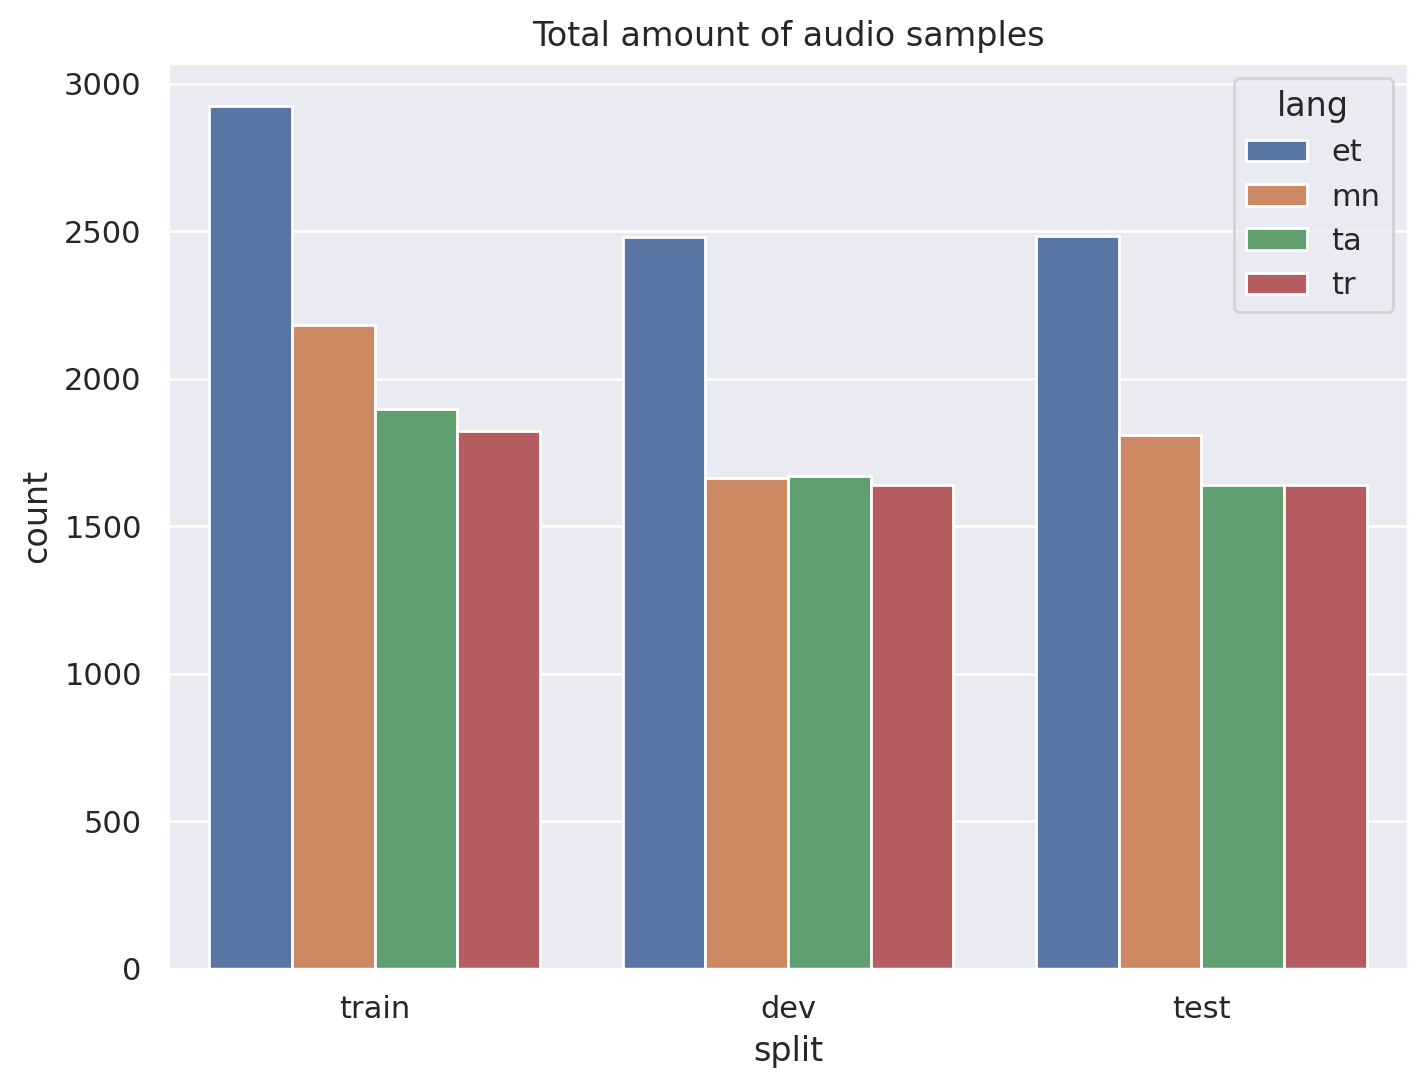

In [7]:
import seaborn as sns


sns.set(rc={'figure.figsize': (8, 6)})
ax = sns.countplot(
    x="split",
    order=split_names,
    hue="lang",
    hue_order=target2lang,
    data=meta)
ax.set_title("Total amount of audio samples")
plt.show()

We can see that the amount of samples with Mongolian, Tamil, and Turkish speech are quite balanced, but we have significantly larger amounts of Estonian speech.
More data is of course always better, but if there is too much of one label compared to the others, our neural network might overfit on this label.

But these are only the counts of audio files, how much speech do we have in total per language?
We need to read every file to get a reliable answer.
See also [SoX](http://sox.sourceforge.net/Main/HomePage) for a good command line tool.

In [8]:
import miniaudio


meta["duration"] = np.array([
    miniaudio.mp3_get_file_info(path).duration for path in meta.path], np.float32)
meta

client_id  \
id                                                                    
et_18031888_test  e570aa634f53f3496f29b20b54b7fc501e1b5b9e6d2cfc...   
et_18031889_test  e570aa634f53f3496f29b20b54b7fc501e1b5b9e6d2cfc...   
et_18031891_test  e570aa634f53f3496f29b20b54b7fc501e1b5b9e6d2cfc...   
et_18038135_test  b6fc7a62e442937e5e60891e8a1bc49df76c2bd0477671...   
et_18038136_test  b6fc7a62e442937e5e60891e8a1bc49df76c2bd0477671...   
...                                                             ...   
tr_22462713_test  f58bab150fb6d452f028697b97e9032d372452c9e60022...   
tr_22474271_test  110ef1bc367a63b877f98d637e4df8e7425c7b75a2d480...   
tr_22474274_test  110ef1bc367a63b877f98d637e4df8e7425c7b75a2d480...   
tr_22477339_test  25e40b1938d0956ccae093f3a4d160fb3759eafa9e162b...   
tr_22498670_test  b925da8c206e5269e2cdfe67e201e7d120ed03d1cae5df...   

                                                               path  \
id                                                                    
et_18031888_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18031889_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18031891_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18038135_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18038136_test  /data/common-voice/cv-corpus/et/clips/common_v...   
...                                                             ...   
tr_22462713_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22474271_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22474274_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22477339_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22498670_test  /data/common-voice/cv-corpus/tr/clips/common_v...   

                                                           sentence lang  \
id                                                                         
et_18031888_test  Aleksejevi sõnul on ka selle osa laevast disai...   et   
et_18031889_test  Nende kategooriate alla mahuvad nii seinamaali...   et   
et_18031891_test                  Ära keeda liiga püdelaks massiks.   et   
et_18038135_test  Mitmed lasteaiad ja ka omavalitsused on oma in...   et   
et_18038136_test  Maastikuarhitektide liidu aastapreemiate nomin...   et   
...                                                             ...  ...   
tr_22462713_test                                                 üç   tr   
tr_22474271_test                                               evet   tr   
tr_22474274_test                                                Hey   tr   
tr_22477339_test                                              dokuz   tr   
tr_22498670_test                                              hayır   tr   

                 split target  duration  
id                                       
et_18031888_test  test      0     5.952  
et_18031889_test  test      0     8.928  
et_18031891_test  test      0     3.336  
et_18038135_test  test      0     9.816  
et_18038136_test  test      0     5.904  
...                ...    ...       ...  
tr_22462713_test  test      3     2.208  
tr_22474271_test  test      3     4.176  
tr_22474274_test  test      3     2.424  
tr_22477339_test  test      3     2.424  
tr_22498670_test  test      3     2.616  

[23842 rows x 7 columns]

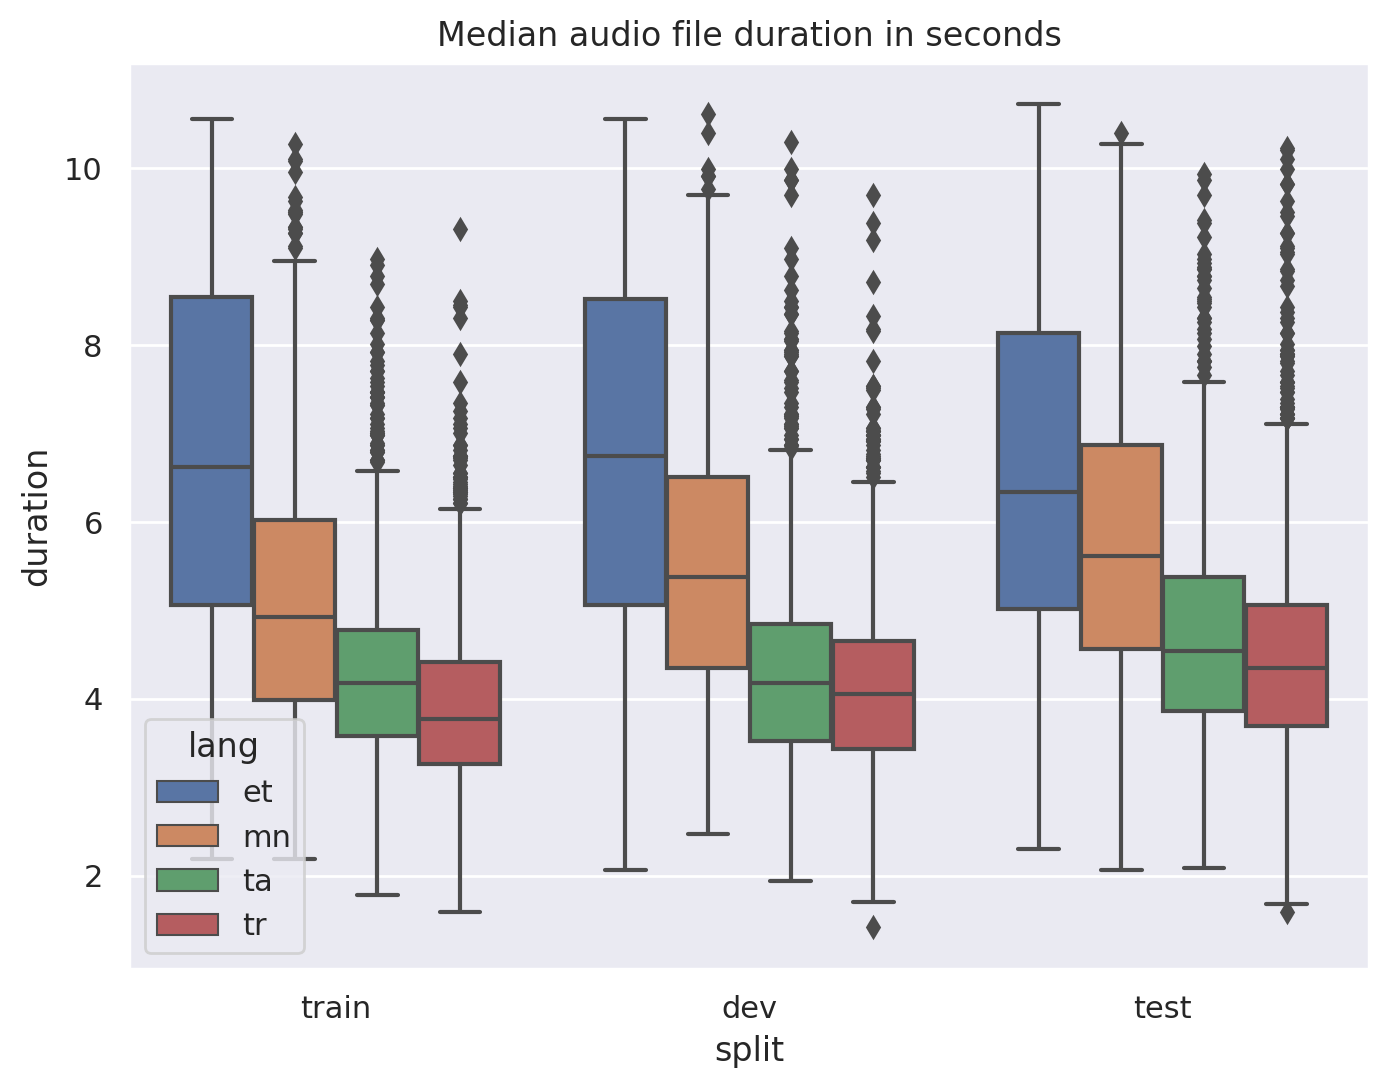

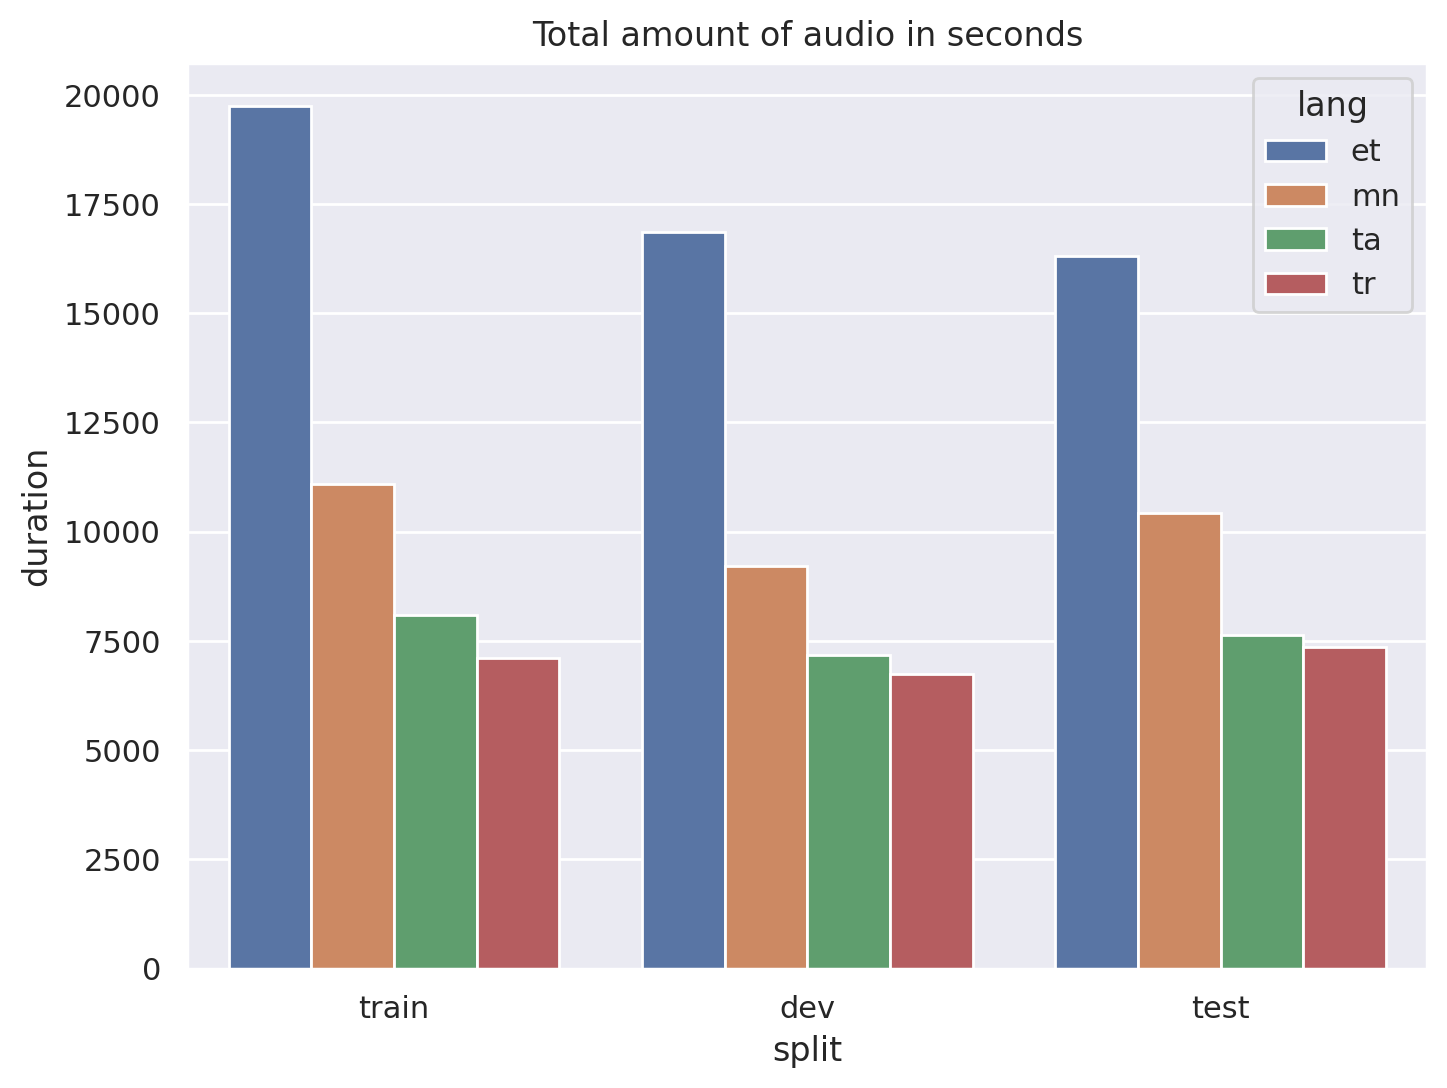

In [9]:
def plot_duration_distribution(data):
    sns.set(rc={'figure.figsize': (8, 6)})
    
    ax = sns.boxplot(
        x="split",
        order=split_names,
        y="duration",
        hue="lang",
        hue_order=target2lang,
        data=data)
    ax.set_title("Median audio file duration in seconds")
    plt.show()

    ax = sns.barplot(
        x="split",
        order=split_names,
        y="duration",
        hue="lang",
        hue_order=target2lang,
        data=data,
        ci=None,
        estimator=np.sum)
    ax.set_title("Total amount of audio in seconds")
    plt.show()


plot_duration_distribution(meta)

The median length of Estonian samples is approx. 2.5 seconds greater compared to Turkish samples, which have the shortest median length.
We can also see that the total amount of Estonian speech is much larger compared to other languages in our datasets.
Notice also the significant amount of outliers with long duration in the Tamil and Turkish datasets.

Lets do simple random oversampling for the training split using this approach:

1. Select the target language according to maximum total amount of speech in seconds (Estonian).
2. Compute differences in total durations between the target language and the three other languages.
3. Compute median signal length by language.
4. Compute sample sizes by dividing the duration deltas with median signal lengths, separately for each language.
5. Draw samples with replacement from the metadata separately for each language.
6. Merge samples with rest of the metadata and verify there are no duplicate ids.

target lang: et
total durations:


duration
lang              
et    19753.007812
mn    11101.583984
ta     8085.552246
tr     7110.624023

total duration delta to target lang:


duration
lang              
et        0.000000
mn     8651.423828
ta    11667.455078
tr    12642.383789

median durations:


duration
lang          
et       6.624
mn       4.920
ta       4.176
tr       3.768

median duration weighted sample sizes based on total duration differences:


duration
lang          
et           0
mn        1758
ta        2793
tr        3355

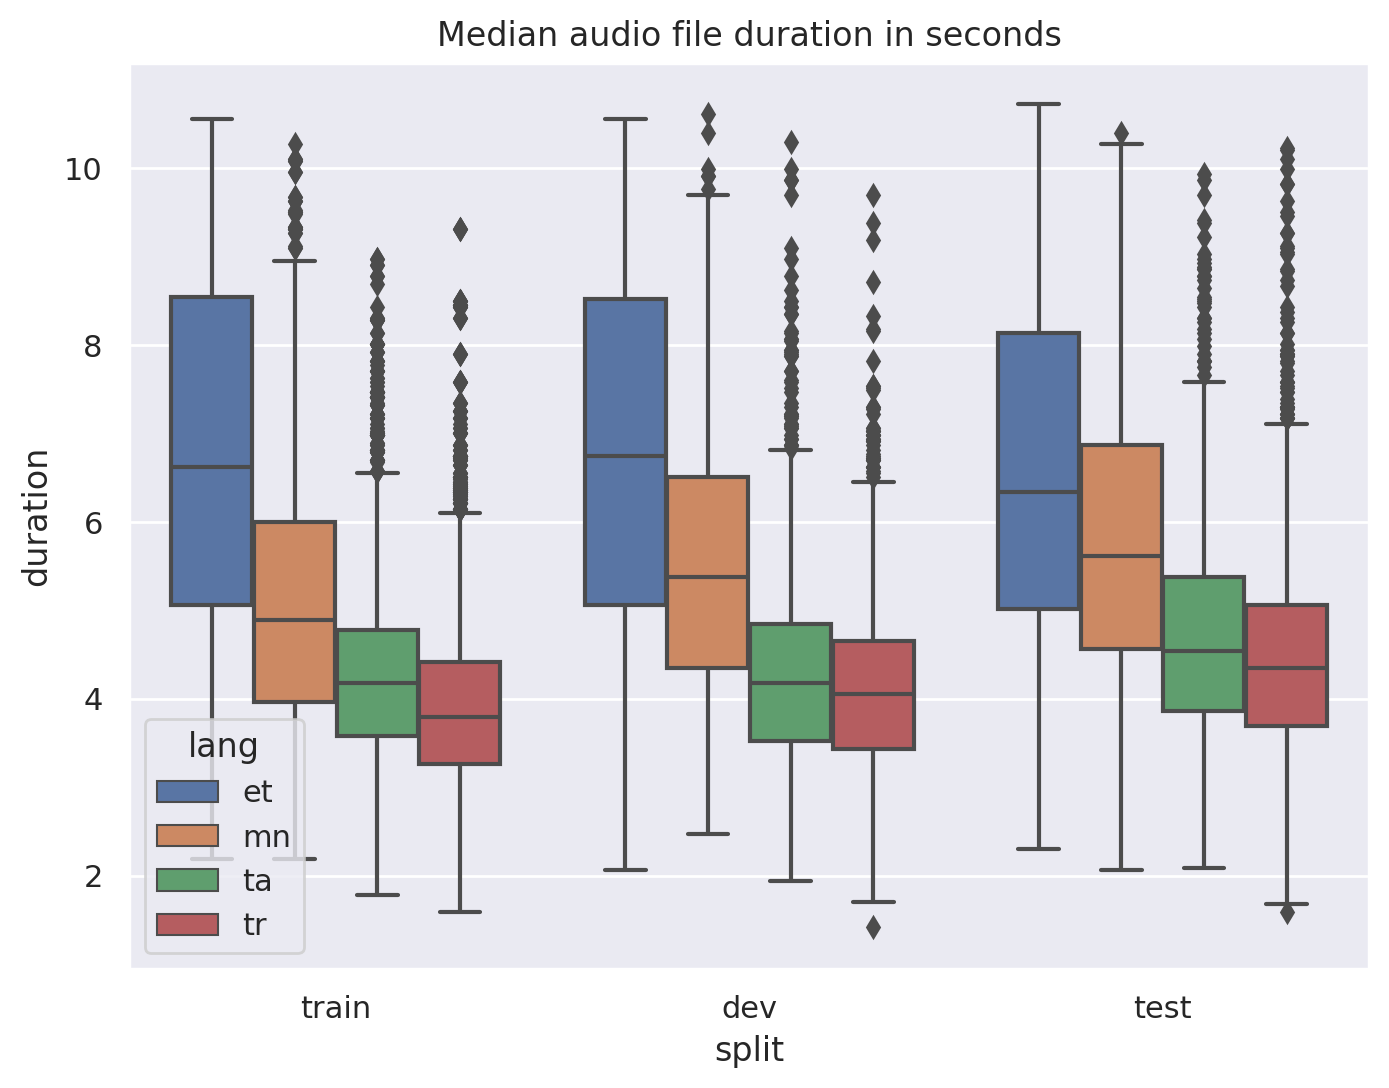

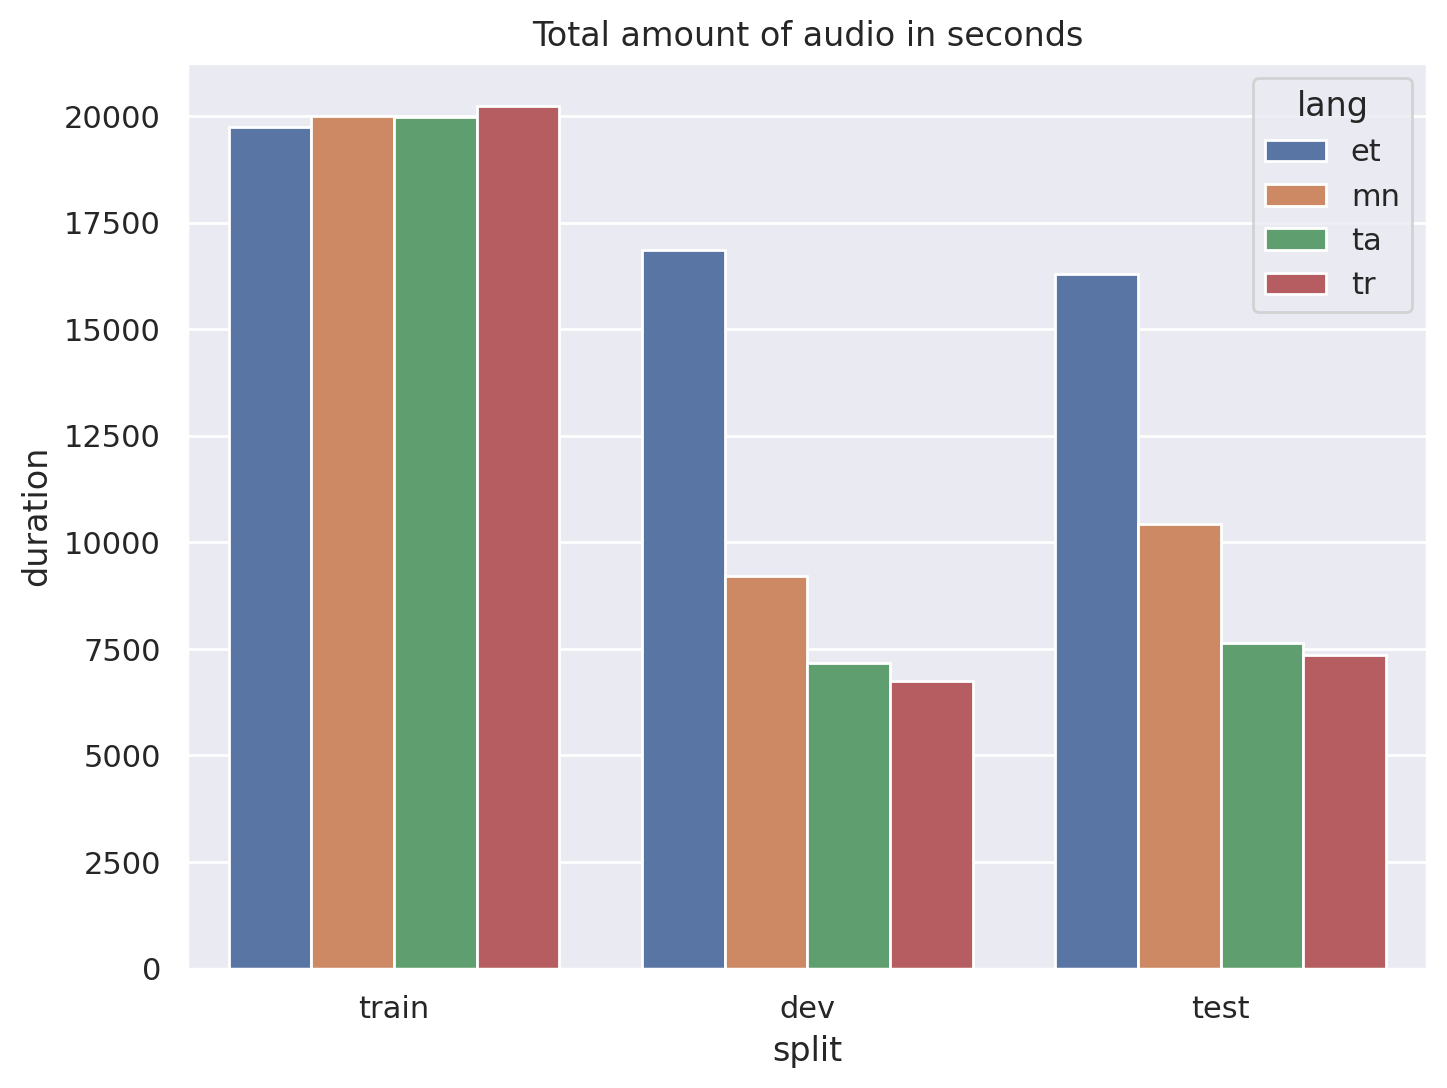

split train has 162 speakers
split dev has 257 speakers
split test has 1057 speakers

asserting all are disjoint
ok


client_id  \
id                                                                    
et_18031888_test  e570aa634f53f3496f29b20b54b7fc501e1b5b9e6d2cfc...   
et_18031889_test  e570aa634f53f3496f29b20b54b7fc501e1b5b9e6d2cfc...   
et_18031891_test  e570aa634f53f3496f29b20b54b7fc501e1b5b9e6d2cfc...   
et_18038135_test  b6fc7a62e442937e5e60891e8a1bc49df76c2bd0477671...   
et_18038136_test  b6fc7a62e442937e5e60891e8a1bc49df76c2bd0477671...   
...                                                             ...   
tr_22462713_test  f58bab150fb6d452f028697b97e9032d372452c9e60022...   
tr_22474271_test  110ef1bc367a63b877f98d637e4df8e7425c7b75a2d480...   
tr_22474274_test  110ef1bc367a63b877f98d637e4df8e7425c7b75a2d480...   
tr_22477339_test  25e40b1938d0956ccae093f3a4d160fb3759eafa9e162b...   
tr_22498670_test  b925da8c206e5269e2cdfe67e201e7d120ed03d1cae5df...   

                                                               path  \
id                                                                    
et_18031888_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18031889_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18031891_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18038135_test  /data/common-voice/cv-corpus/et/clips/common_v...   
et_18038136_test  /data/common-voice/cv-corpus/et/clips/common_v...   
...                                                             ...   
tr_22462713_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22474271_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22474274_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22477339_test  /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_22498670_test  /data/common-voice/cv-corpus/tr/clips/common_v...   

                                                           sentence lang  \
id                                                                         
et_18031888_test  Aleksejevi sõnul on ka selle osa laevast disai...   et   
et_18031889_test  Nende kategooriate alla mahuvad nii seinamaali...   et   
et_18031891_test                  Ära keeda liiga püdelaks massiks.   et   
et_18038135_test  Mitmed lasteaiad ja ka omavalitsused on oma in...   et   
et_18038136_test  Maastikuarhitektide liidu aastapreemiate nomin...   et   
...                                                             ...  ...   
tr_22462713_test                                                 üç   tr   
tr_22474271_test                                               evet   tr   
tr_22474274_test                                                Hey   tr   
tr_22477339_test                                              dokuz   tr   
tr_22498670_test                                              hayır   tr   

                 split target duration  
id                                      
et_18031888_test  test      0    5.952  
et_18031889_test  test      0    8.928  
et_18031891_test  test      0    3.336  
et_18038135_test  test      0    9.816  
et_18038136_test  test      0    5.904  
...                ...    ...      ...  
tr_22462713_test  test      3    2.208  
tr_22474271_test  test      3    4.176  
tr_22474274_test  test      3    2.424  
tr_22477339_test  test      3    2.424  
tr_22498670_test  test      3    2.616  

[31748 rows x 7 columns]

In [10]:
def random_oversampling(meta):
    groupby_lang = meta[["lang", "duration"]].groupby("lang")
    
    total_dur = groupby_lang.sum()
    target_lang = total_dur.idxmax()[0]
    print("target lang:", target_lang)
    print("total durations:")
    display(total_dur)
    
    total_dur_delta = total_dur.loc[target_lang] - total_dur
    print("total duration delta to target lang:")
    display(total_dur_delta)
    
    median_dur = groupby_lang.median()
    print("median durations:")
    display(median_dur)
    
    sample_sizes = (total_dur_delta / median_dur).astype(np.int32)
    print("median duration weighted sample sizes based on total duration differences:")
    display(sample_sizes)
    
    samples = []
    
    for lang in groupby_lang.groups:
        sample_size = sample_sizes.loc[lang][0]
        sample = (meta[meta["lang"]==lang]
                  .sample(n=sample_size, replace=True, random_state=np_rng.bit_generator)
                  .reset_index()
                  .transform(update_sample_id, axis=1))
        samples.append(sample)

    return pd.concat(samples).set_index("id", drop=True, verify_integrity=True)


def update_sample_id(row):
    row["id"] = "{}_copy_{}".format(row["id"], row.name)
    return row

    
# Augment training set metadata
meta = pd.concat([random_oversampling(meta[meta["split"]=="train"]), meta]).sort_index()

assert not meta.isna().any(axis=None), "NaNs in metadata after augmentation"
plot_duration_distribution(meta)
assert_splits_disjoint_by_speaker(meta)
meta

Speech data augmentation is a common research topic.
There are [better](https://www.isca-speech.org/archive/interspeech_2015/papers/i15_3586.pdf) ways to augment data than the simple duplication of metadata rows we did here.
One approach (which we won't be doing here) which is easy to implement and might work well is to take copies of signals and make them randomly a bit faster or slower.
For example, draw randomly speed ratios from `[0.9, 1.1]` and resample the signal by multiplying its sample rate with the random ratio.

## Inspecting the audio

Lets take a look at the speech data and listen to a few randomly picked samples from each label.
We pick 2 random samples for each language from the training set.

In [11]:
samples = (meta[meta["split"]=="train"]
           .groupby("lang")
           .sample(n=2, random_state=np_rng.bit_generator))
samples

client_id  \
id                                                                              
et_18309293_train           a1fe9d415a381158a7fb89978304161183e0795c65d0b3...   
et_20816668_train           723cd1a56681e4c3dbeb36ceac204f435fa517dd8a94d4...   
mn_19023260_train           74c6df0d177aacb734c2ea4052772610dcfc860656bd8b...   
mn_18598365_train_copy_695  be1b9005c04889bbf9759a71dbe046be839ee068a668f4...   
ta_19093638_train           6622032a09c9f7e0fbb3bddc0a33304509ca3f33ec79fe...   
ta_20435594_train           7d61a7238caeb62624af2b9c202edbfc534e7955658646...   
tr_19847090_train           7af2e0f706baed314ca0f96efe612ea592bf57791a348b...   
tr_21324796_train           7b735c8f538c3bae9b0d2a63492fb70a49d214173903d3...   

                                                                         path  \
id                                                                              
et_18309293_train           /data/common-voice/cv-corpus/et/clips/common_v...   
et_20816668_train           /data/common-voice/cv-corpus/et/clips/common_v...   
mn_19023260_train           /data/common-voice/cv-corpus/mn/clips/common_v...   
mn_18598365_train_copy_695  /data/common-voice/cv-corpus/mn/clips/common_v...   
ta_19093638_train           /data/common-voice/cv-corpus/ta/clips/common_v...   
ta_20435594_train           /data/common-voice/cv-corpus/ta/clips/common_v...   
tr_19847090_train           /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_21324796_train           /data/common-voice/cv-corpus/tr/clips/common_v...   

                                                                     sentence  \
id                                                                              
et_18309293_train           Meresmaa ütleb, et hoolimata sellest, kas puid...   
et_20816668_train           Keegi ei arva ka, et need ei peaks olema kalli...   
mn_19023260_train           Жэймстэй ширүүхэн маргалдсаны улмаас Бенжамин ...   
mn_18598365_train_copy_695       Болж өгвөл сүүдрээсээ хүртэл болгоомжилж яв.   
ta_19093638_train           மிஞ்சுகின்ற காதலின்மேல் ஆணையிட்டு விள்ளுகின்றேன்!   
ta_20435594_train                            தெருவார் வந்து சேர்ந்தார் உள்ளே.   
tr_19847090_train                            Ancak daha yapılacak çok iş var.   
tr_21324796_train              Bundan sonra bir şeylerin değişmesi gerekecek.   

                           lang  split target duration  
id                                                      
et_18309293_train            et  train      0    8.736  
et_20816668_train            et  train      0    4.584  
mn_19023260_train            mn  train      1    6.336  
mn_18598365_train_copy_695   mn  train      1    3.864  
ta_19093638_train            ta  train      2    5.304  
ta_20435594_train            ta  train      2    3.888  
tr_19847090_train            tr  train      3    3.744  
tr_21324796_train            tr  train      3    4.584

Then lets read the mp3-files from disk, plot the signals, and listen to the audio.

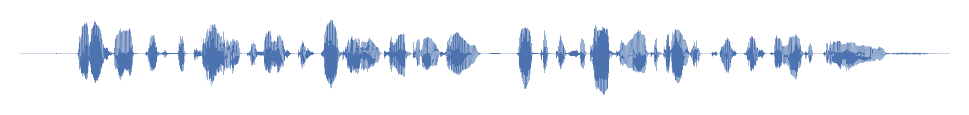

length: 8.736 sec
lang: et
sentence: Meresmaa ütleb, et hoolimata sellest, kas puidu all on kivipõrand või ei, jaotatakse kaabel mööda põrandat ühtlaste loogetena laiali.


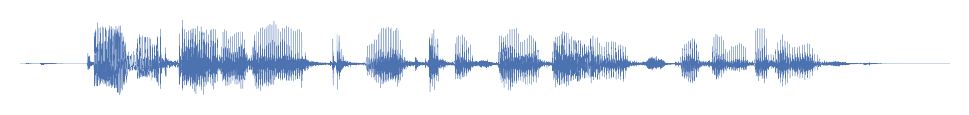

length: 4.584 sec
lang: et
sentence: Keegi ei arva ka, et need ei peaks olema kallimad kui tavaravimid.


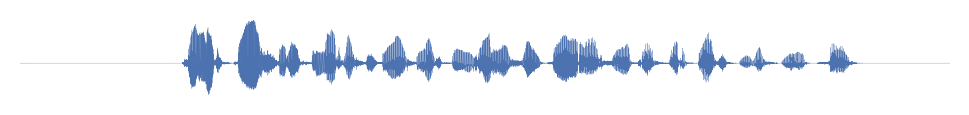

length: 6.336 sec
lang: mn
sentence: Жэймстэй ширүүхэн маргалдсаны улмаас Бенжамин хувь заяагаа хайж олохоор Бостоныг орхин одлоо.


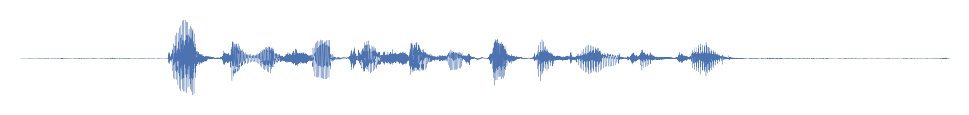

length: 3.864 sec
lang: mn
sentence: Болж өгвөл сүүдрээсээ хүртэл болгоомжилж яв.


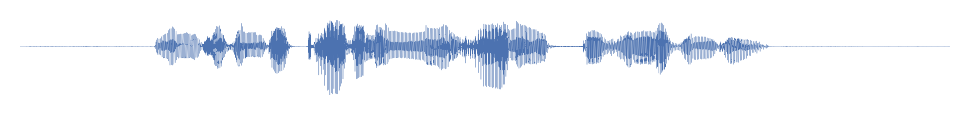

length: 5.304 sec
lang: ta
sentence: மிஞ்சுகின்ற காதலின்மேல் ஆணையிட்டு விள்ளுகின்றேன்!


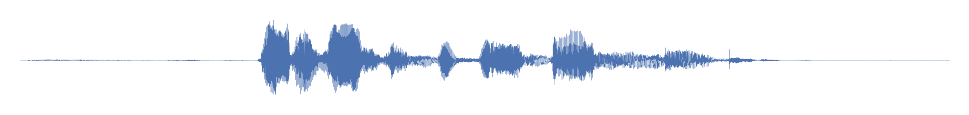

length: 3.888 sec
lang: ta
sentence: தெருவார் வந்து சேர்ந்தார் உள்ளே.


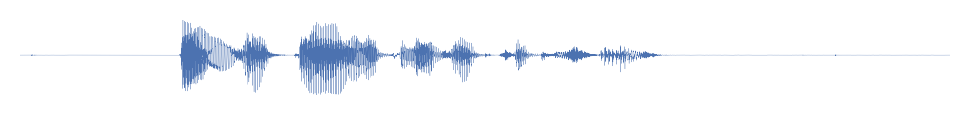

length: 3.744 sec
lang: tr
sentence: Ancak daha yapılacak çok iş var.


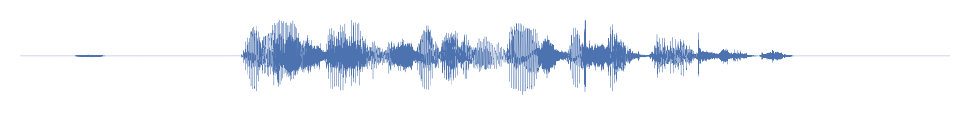

length: 4.584 sec
lang: tr
sentence: Bundan sonra bir şeylerin değişmesi gerekecek.


In [12]:
from IPython.display import display, Audio, HTML
import scipy.signal


def read_mp3(path, resample_rate=16000):
    if isinstance(path, bytes):
        # If path is a tf.string tensor, it will be in bytes
        path = path.decode("utf-8")
        
    f = miniaudio.mp3_read_file_f32(path)
    
    # Downsample to target rate, 16 kHz is commonly used for speech data
    new_len = round(len(f.samples) * float(resample_rate) / f.sample_rate)
    signal = scipy.signal.resample(f.samples, new_len)
    
    # Normalize to [-1, 1]
    signal /= np.abs(signal).max()
    
    return signal, resample_rate


def embed_audio(signal, rate):
    display(Audio(data=signal, rate=rate, embed=True, normalize=False))

    
def plot_signal(data, figsize=(6, 0.5), **kwargs):
    ax = sns.lineplot(data=data, lw=0.1, **kwargs)
    ax.set_axis_off()
    ax.margins(0)
    plt.gcf().set_size_inches(*figsize)
    plt.show()

    
def plot_separator():
    display(HTML(data="<hr style='border: 2px solid'>"))

    
for sentence, lang, clip_path in samples[["sentence", "lang", "path"]].to_numpy():
    signal, rate = read_mp3(clip_path)
    plot_signal(signal)
    print("length: {} sec".format(signal.size / rate))
    print("lang:", lang)
    print("sentence:", sentence)
    embed_audio(signal, rate)
    plot_separator()

One of the most challenging aspects of the Mozilla Common Voice dataset is that the audio quality varies greatly: different microphones, background noise, user is speaking close to the device or far away etc.
It is difficult to ensure that a neural network will learn to classify different languages as opposed to classifying distinct acoustic artefacts from specific microphones.
There's a [vast amount of research](https://www.isca-speech.org/archive/Interspeech_2020/) being done on developing techniques for solving these kind of problems.
However, these are well out of scope for this simple example and we won't be studying them here.


## Spectral representations

It is usually not possible (at least not yet in 2020) to detect languages directly from the waveform.
Instead, the [fast Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (FFT) is applied on small, overlapping windows of the signal to get a 2-dimensional representation of energies in different frequency bands.
See [this](https://wiki.aalto.fi/display/ITSP/Spectrogram+and+the+STFT) for further details.

However, output from the FFT is usually not usable directly and must be refined.
Lets begin by selecting the first signal from our random sample and extract the power spectrogram.

### Power spectrogram

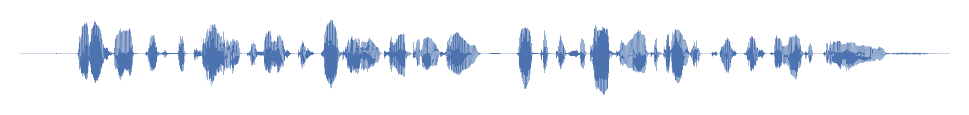

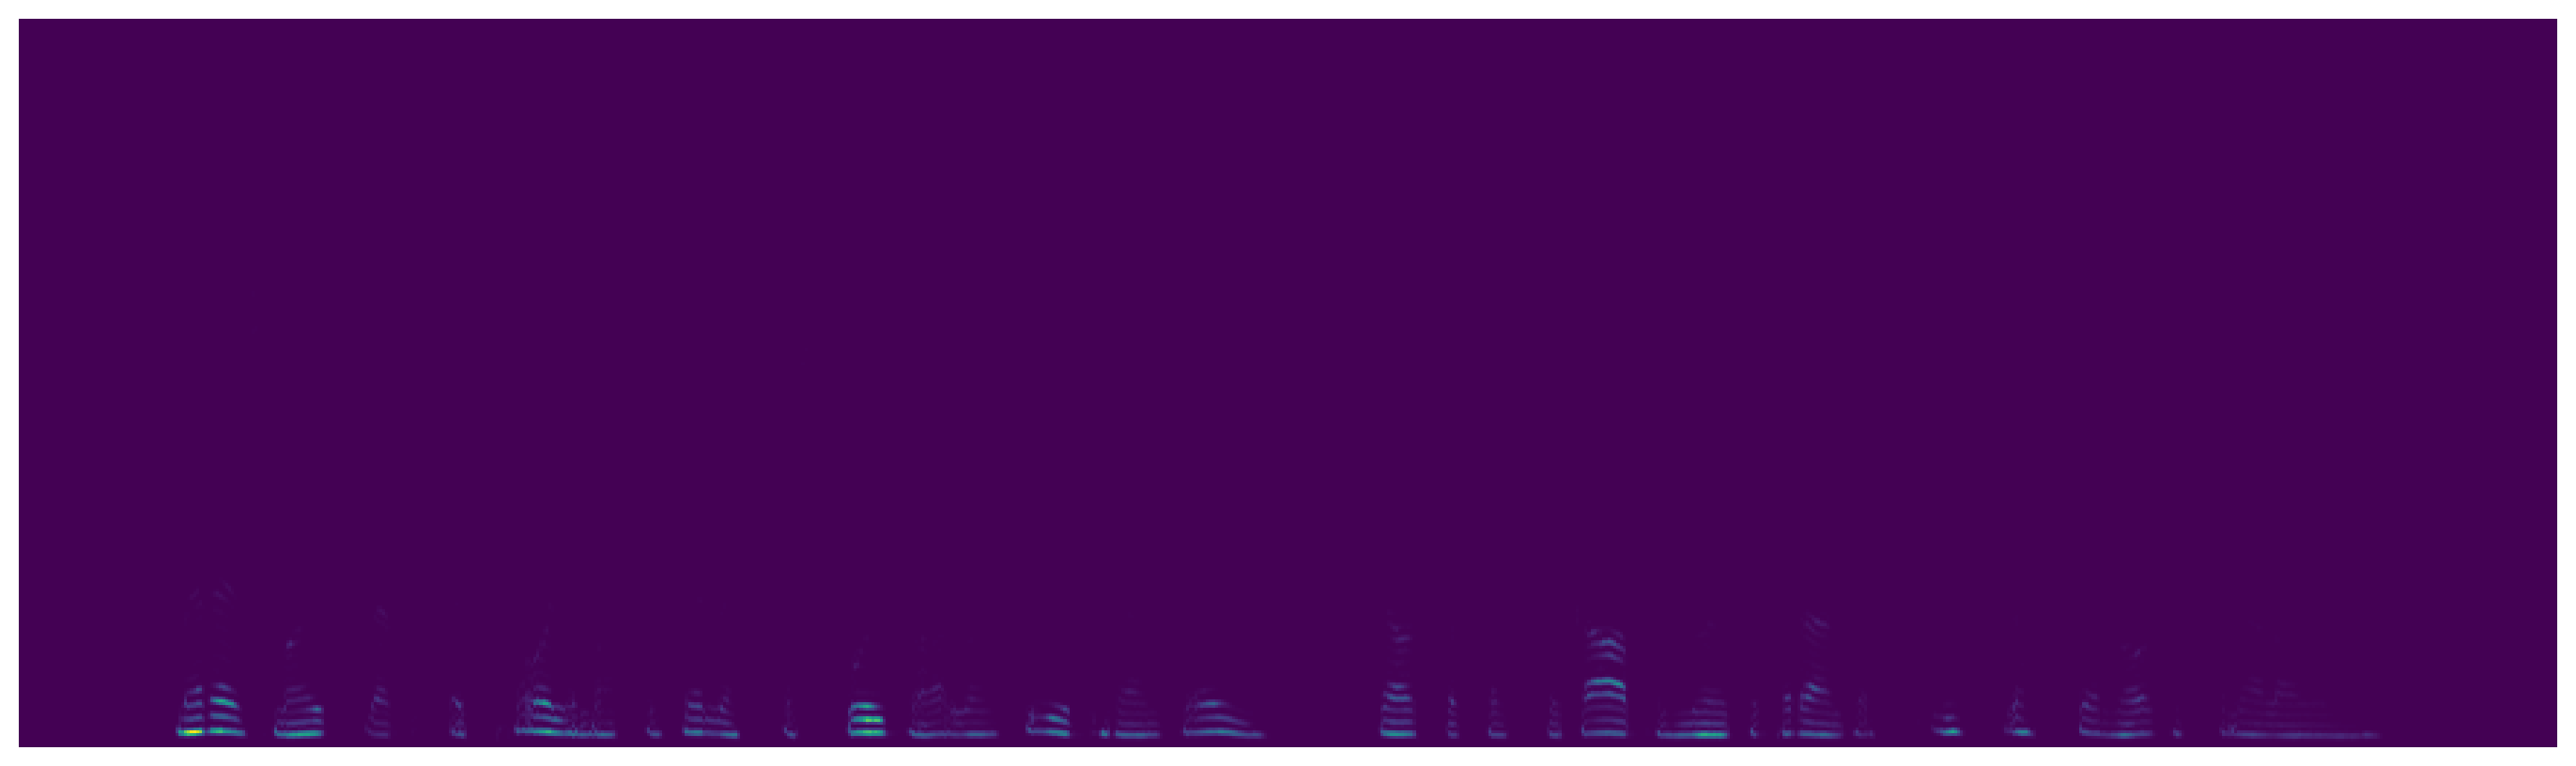

In [13]:
from lidbox.features.audio import spectrograms


def plot_spectrogram(S, cmap="viridis", figsize=None, **kwargs):
    if figsize is None:
        figsize = S.shape[0]/50, S.shape[1]/50
    ax = sns.heatmap(S.T, cbar=False, cmap=cmap, **kwargs)
    ax.invert_yaxis()
    ax.set_axis_off()
    ax.margins(0)
    plt.gcf().set_size_inches(*figsize)
    plt.show()

    
sample = samples[["sentence", "lang", "path"]].to_numpy()[0]
sentence, lang, clip_path = sample

signal, rate = read_mp3(clip_path)
plot_signal(signal)

powspec = spectrograms([signal], rate)[0]

plot_spectrogram(powspec.numpy())

This representation is very sparse, with zeros everywhere except in the lowest frequency bands.
The main problem here is that relative differences between energy values are very large, making it different to compare large changes in energy.
These differences can be reduced by mapping the values onto a logarithmic scale.

The [decibel-scale](https://en.wikipedia.org/wiki/Decibel) is a common choice.
We will use the maximum value of `powspec` as the reference power ($\text{P}_0$).

### Decibel-scale spectrogram

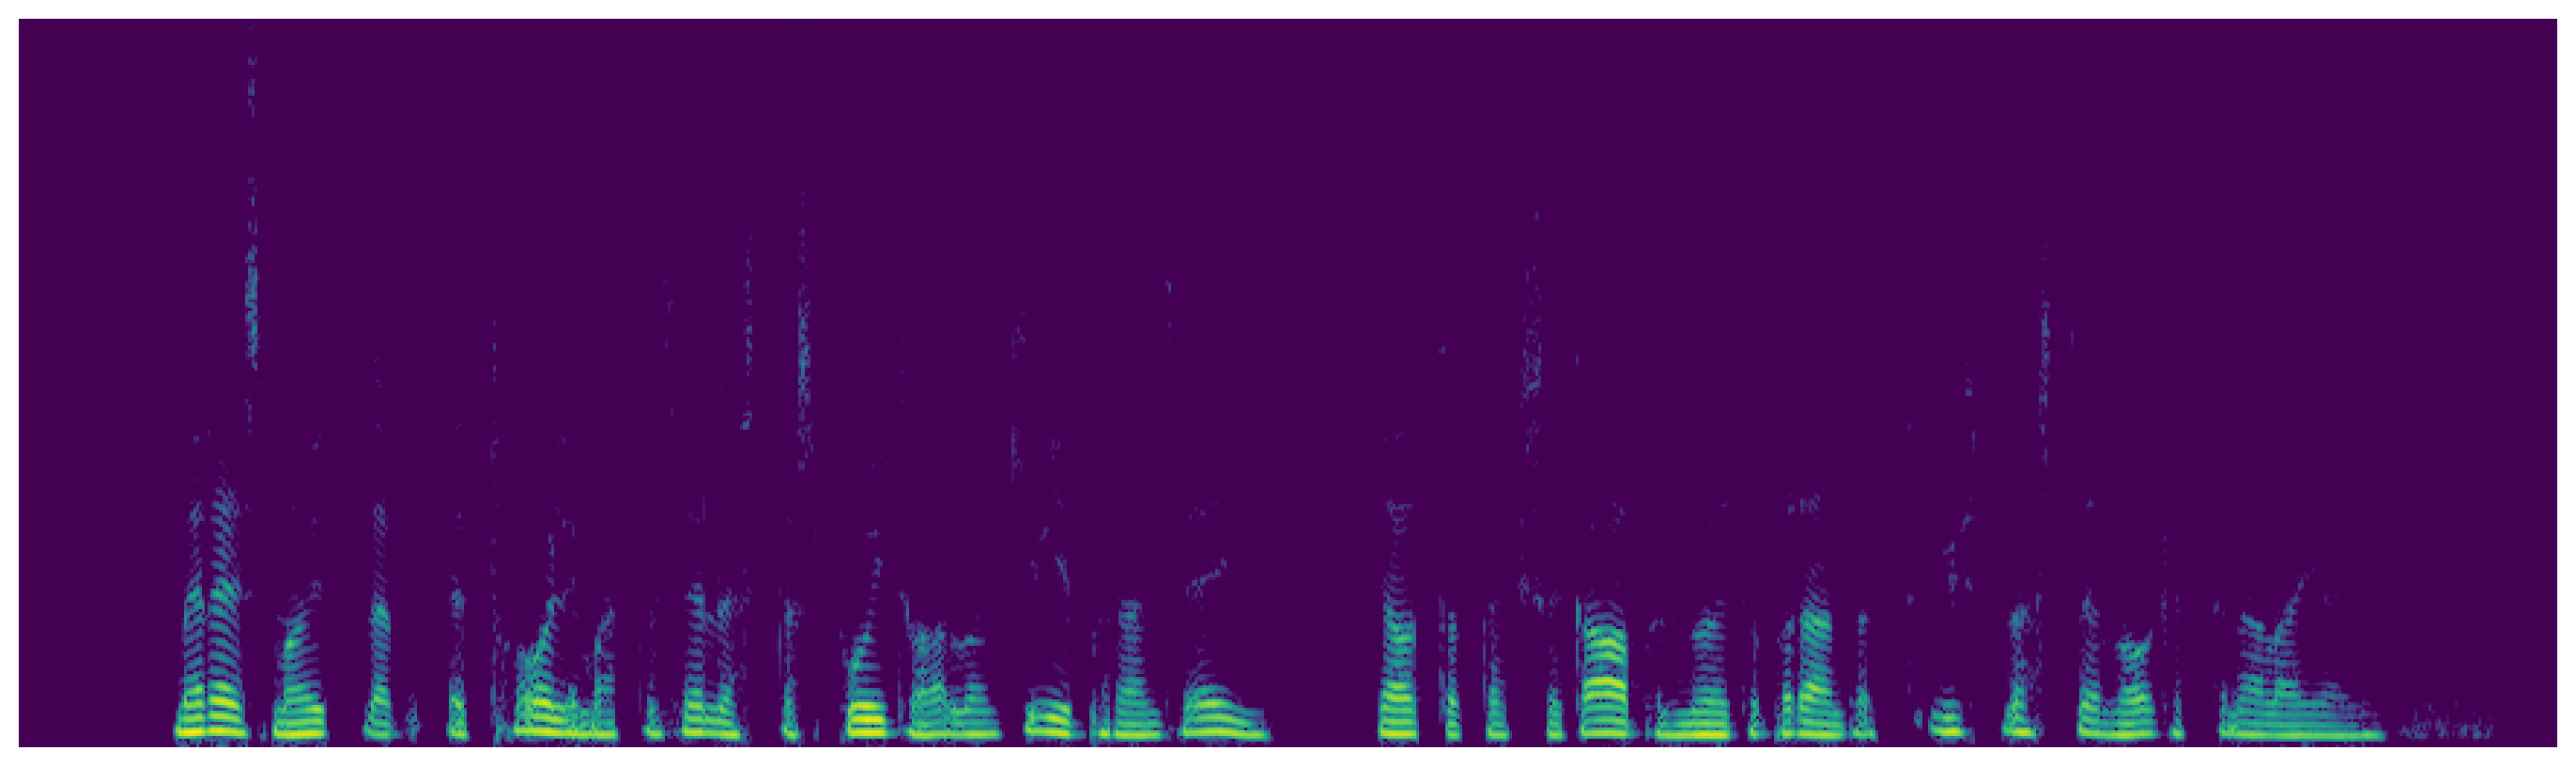

In [14]:
from lidbox.features.audio import power_to_db


dbspec = power_to_db([powspec])[0]
plot_spectrogram(dbspec.numpy())

This is an improvement, but the representation is still rather sparse.
We also see that most speech information is in the lower bands, with a bit of energy in the higher frequencies.
A common approach is to "squeeze together" the y-axis of all frequency bands.
There are many scales for doing this, but we will be using [Mel-scale](https://en.wikipedia.org/wiki/Mel_scale) since it is commonly used in language identification.
Lets "squeeze" the current 256 frequency bins into 64 Mel-bins.

### Log-scale Mel-spectrogram

**Note** that we are scaling different things here.
The Mel-scale warps the frequency bins (y-axis), while the logarithm is used to reduce relative differences between individual spectrogram values (pixels).

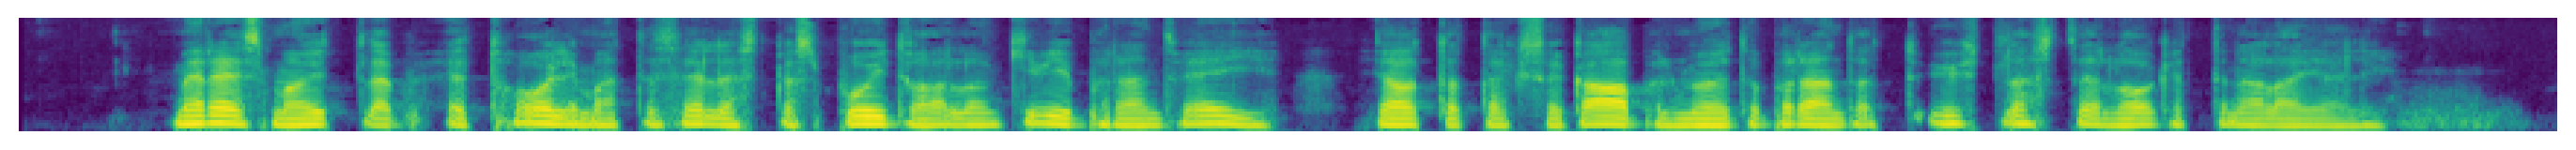

In [15]:
from lidbox.features.audio import linear_to_mel


def logmelspectrograms(signals, rate):
    powspecs = spectrograms(signals, rate)
    melspecs = linear_to_mel(powspecs, rate, num_mel_bins=40)
    return tf.math.log(melspecs + 1e-6)
    

logmelspec = logmelspectrograms([signal], rate)[0]
plot_spectrogram(logmelspec.numpy())

One common normalization technique is frequency channel standardization, i.e. normalization of rows to zero mean and unit variance.

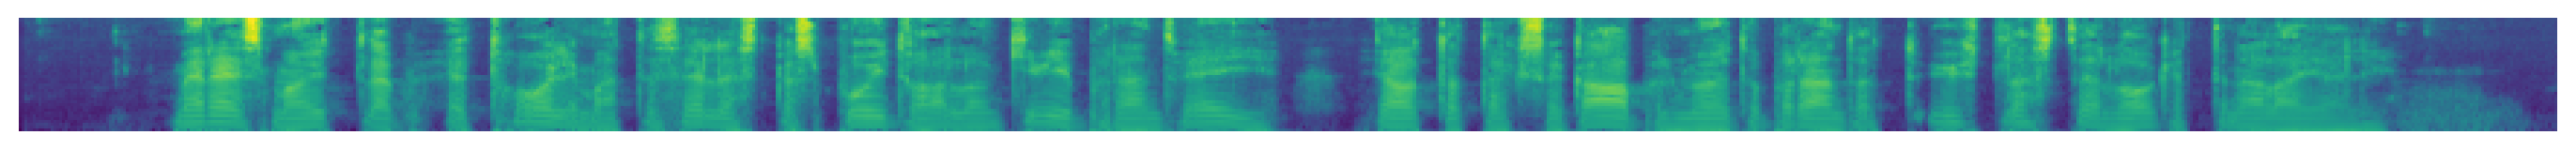

In [16]:
from lidbox.features import cmvn

logmelspec_mv = cmvn([logmelspec])[0]
plot_spectrogram(logmelspec_mv.numpy())

Or only mean-normalization if you think the variances contain important information.

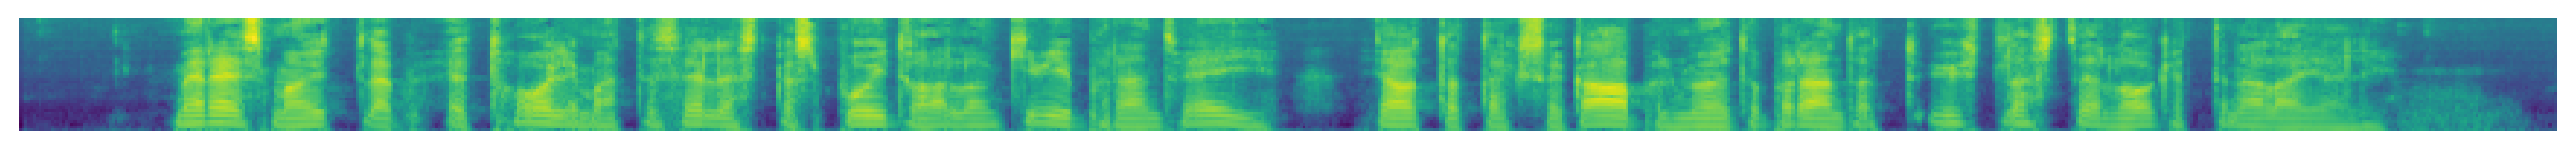

In [17]:
logmelspec_m = cmvn([logmelspec], normalize_variance=False)[0]
plot_spectrogram(logmelspec_m.numpy())

## Cepstral representations

Another common representation are the Mel-frequency cepstral coefficients (MFCC), which are obtained by applying the [discrete cosine transform](https://en.wikipedia.org/wiki/Discrete_cosine_transform) on the log-scale Mel-spectrogram.

### MFCC

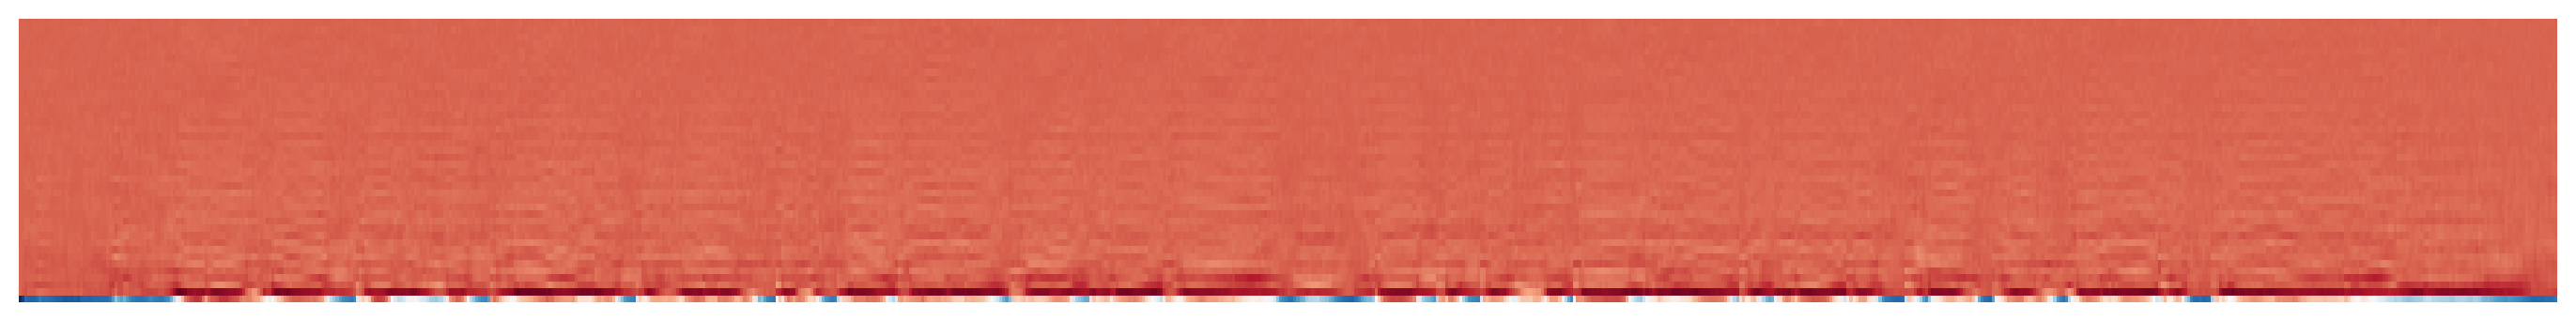

In [18]:
def plot_cepstra(X, figsize=None):
    if not figsize:
        figsize = (X.shape[0]/50, X.shape[1]/20)
    plot_spectrogram(X, cmap="RdBu_r", figsize=figsize)

    
mfcc = tf.signal.mfccs_from_log_mel_spectrograms([logmelspec])[0]
plot_cepstra(mfcc.numpy())

Most of the information is concentrated in the lower coefficients.
It is common to drop the 0th coefficient and select a subset starting at 1, e.g. 1 to 20.
See [this post](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) for more details.

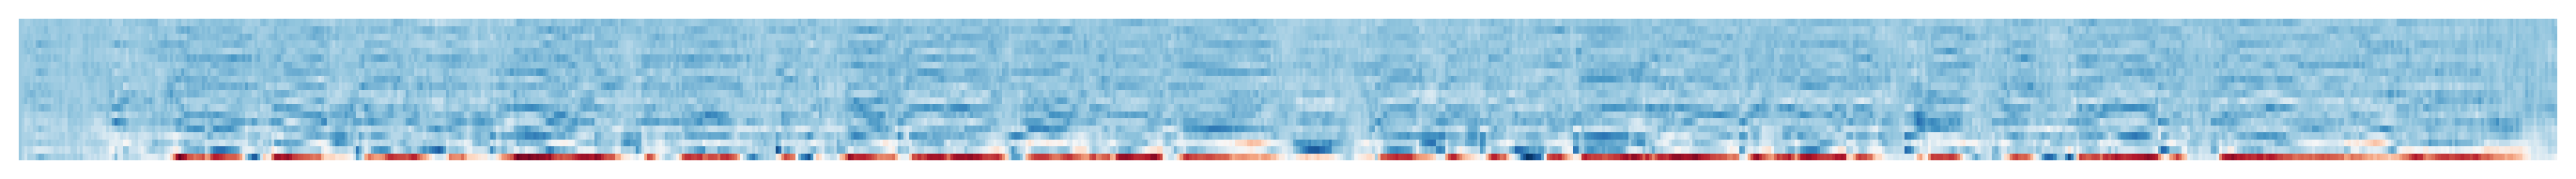

In [19]:
mfcc = mfcc[:,1:21]
plot_cepstra(mfcc.numpy())

Now we have a very compact representation, but most of the variance is still in the lower coefficients and overshadows the smaller changes in higher coefficients.
We can normalize the MFCC matrix row-wise by standardizing each row to zero mean and unit variance.
This is commonly called cepstral mean and variance normalization (CMVN).

### MFCC + CMVN

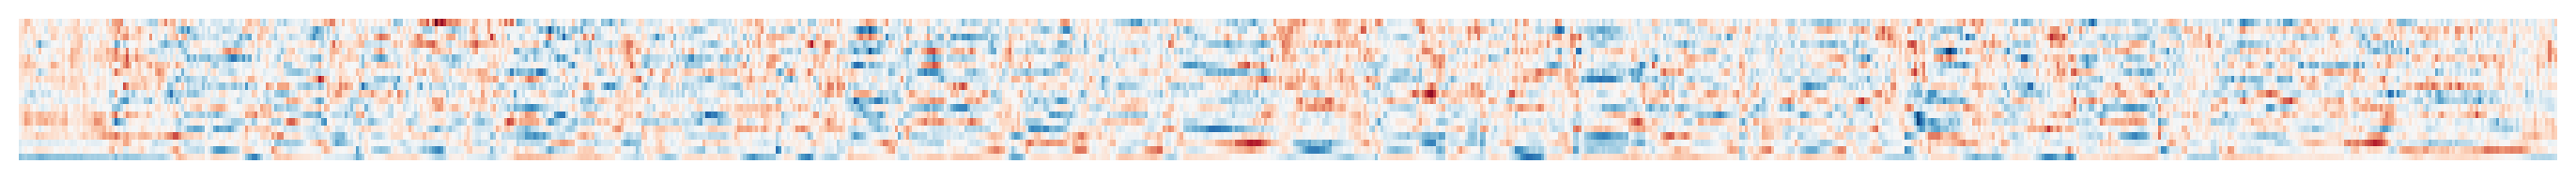

In [20]:
mfcc_cmvn = cmvn([mfcc])[0]
plot_cepstra(mfcc_cmvn.numpy())

### Which one is best?

Speech feature extraction is a large, active research topic and it is impossible to choose one representation that would work well in all situations.
Common choices in state-of-the-art spoken language identification are log-scale Mel-spectrograms and MFCCs, with different normalization approaches.
For example, [here](https://github.com/swshon/dialectID_e2e) is an experiment in Arabic dialect identification, where log-scale Mel-spectra (referred to as FBANK) produced slightly better results compared to MFCCs.

It is not obvious when to choose which representation, or if we should even use the FFT at all.
You can read [this post](https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html) for a more detailed discussion.

## Voice activity detection

It is common for speech datasets to contain audio samples with short segments of silence or sounds that are not speech.
Since these are usually irrelevant for making a language classification decision, we would prefer to discard such segments.
This is called voice activity detection (VAD) and it is another large, active research area.
[Here](https://wiki.aalto.fi/pages/viewpage.action?pageId=151500905) is a brief overview of VAD. 

Non-speech segments can be either noise or silence. 
Separating non-speech noise from speech is non-trivial but possible, for example with [neural networks](https://www.isca-speech.org/archive/Interspeech_2019/pdfs/1354.pdf).
Silence, on the other hand, shows up as zeros in our speech representations, since these segments contain lower energy values compared to segments with speech.
Such non-speech segments are therefore easy to detect and discard, for example by comparing the energy of the segment to the average energy of the whole sample.

If the samples in our example do not contain much background noise, a simple energy-based VAD technique should be enough to drop all silent segments.
We'll use the [root mean square](https://en.wikipedia.org/wiki/Root_mean_square) (RMS) energy to detect short silence segments.
`lidbox` has a simple energy-based VAD function, which we will use as follows:

1. Divide the signal into non-overlapping 10 ms long windows.
2. Compute RMS of each window.
3. Reduce all window RMS values by averaging to get a single mean RMS value.
4. Set a decision threshold at 0.1 for marking silence windows. In other words, if the window RMS is less than 0.1 of the mean RMS, mark the window as silence.


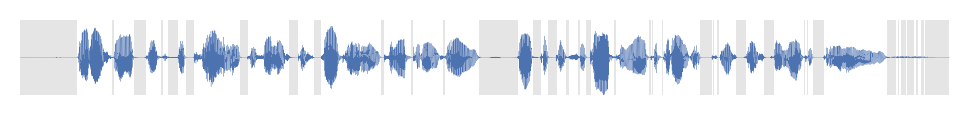

lang: et
sentence: 'Meresmaa ütleb, et hoolimata sellest, kas puidu all on kivipõrand või ei, jaotatakse kaabel mööda põrandat ühtlaste loogetena laiali.'


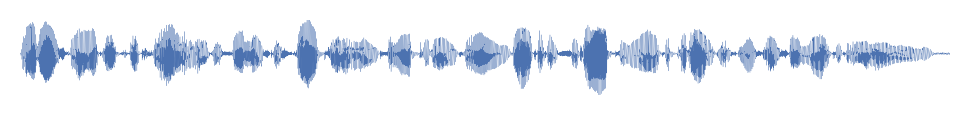

dropped 43936 out of 139776 frames, leaving 0.686 of the original signal


In [21]:
from lidbox.features.audio import framewise_rms_energy_vad_decisions
import matplotlib.patches as patches


sentence, lang, clip_path = sample
signal, rate = read_mp3(clip_path)

window_ms = tf.constant(10, tf.int32)
window_frame_length = (window_ms * rate) // 1000

# Get binary VAD decisions for each 10 ms window
vad_1 = framewise_rms_energy_vad_decisions(
    signal=signal,
    sample_rate=rate,
    frame_step_ms=window_ms,
    strength=0.1)

# Plot unfiltered signal
sns.set(rc={'figure.figsize': (6, 0.5)})
ax = sns.lineplot(data=signal, lw=0.1, legend=None)
ax.set_axis_off()
ax.margins(0)

# Plot shaded area over samples marked as not speech (VAD == 0)
for x, is_speech in enumerate(vad_1.numpy()):
    if not is_speech:
        rect = patches.Rectangle(
            (x*window_frame_length, -1),
            window_frame_length,
            2,
            linewidth=0,
            color='gray',
            alpha=0.2)
        ax.add_patch(rect)
plt.show()

print("lang:", lang)
print("sentence: '{}'".format(sentence))
embed_audio(signal, rate)

# Partition the signal into 10 ms windows to match the VAD decisions
windows = tf.signal.frame(signal, window_frame_length, window_frame_length)
# Filter signal with VAD decision == 1 (remove gray areas)
filtered_signal = tf.reshape(windows[vad_1], [-1])

plot_signal(filtered_signal)
print("dropped {:d} out of {:d} frames, leaving {:.3f} of the original signal".format(
    signal.shape[0] - filtered_signal.shape[0],
    signal.shape[0],
    filtered_signal.shape[0]/signal.shape[0]))
embed_audio(filtered_signal, rate)

The filtered signal has less silence, but some of the pauses between words sound too short and unnatural.
We would prefer not to remove small pauses that normally occur between words, so lets say all pauses shorter than 300 ms should not be filtered out.
Lets also move all VAD code into a function.

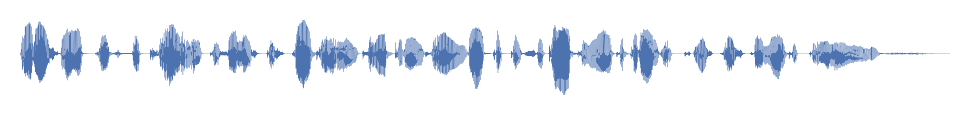

dropped 14656 out of 139776 frames, leaving 0.895 of the original signal
lang: et
sentence: 'Meresmaa ütleb, et hoolimata sellest, kas puidu all on kivipõrand või ei, jaotatakse kaabel mööda põrandat ühtlaste loogetena laiali.'


In [22]:
def remove_silence(signal, rate):
    window_ms = tf.constant(10, tf.int32)
    window_frames = (window_ms * rate) // 1000
    
    # Get binary VAD decisions for each 10 ms window
    vad_1 = framewise_rms_energy_vad_decisions(
        signal=signal,
        sample_rate=rate,
        frame_step_ms=window_ms,
        # Do not return VAD = 0 decisions for sequences shorter than 300 ms
        min_non_speech_ms=300,
        strength=0.1)
    
    # Partition the signal into 10 ms windows to match the VAD decisions
    windows = tf.signal.frame(signal, window_frames, window_frames)
    # Filter signal with VAD decision == 1
    return tf.reshape(windows[vad_1], [-1])


sentence, lang, clip_path = sample
signal, rate = read_mp3(clip_path)

filtered_signal = remove_silence(signal, rate)
plot_signal(filtered_signal)

print("dropped {:d} out of {:d} frames, leaving {:.3f} of the original signal".format(
    signal.shape[0] - filtered_signal.shape[0],
    signal.shape[0],
    filtered_signal.shape[0]/signal.shape[0]))

print("lang:", lang)
print("sentence: '{}'".format(sentence))
embed_audio(filtered_signal, rate)

We dropped some silence segments but left most of the speech intact, perhaps this is enough for our example.

Although this VAD approach is simple and works ok for our data, it will not work for speech data with non-speech sounds in the background like music or noise.
For such data we might need more powerful VAD filters such as neural networks that have been trained on a speech vs non-speech classification task with large amounts of different noise.

But lets not add more complexity to our example.
We'll use the RMS based filter for all other signals too.

## Comparison of representations

Lets extract these features for all signals in our random sample.

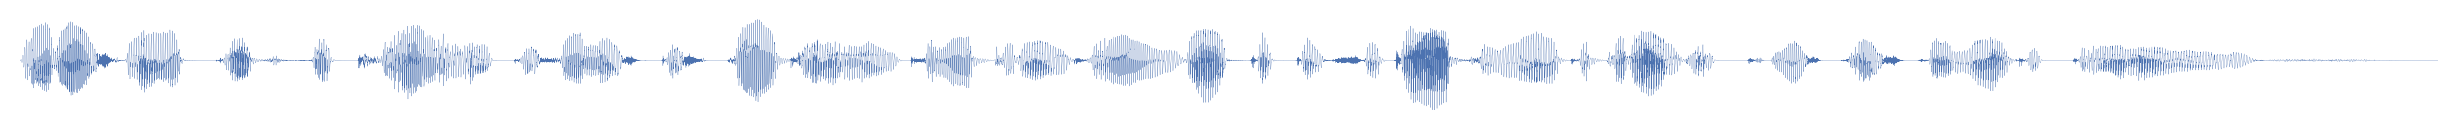

VAD: 8.736 -> 7.82 sec
lang: et
sentence: Meresmaa ütleb, et hoolimata sellest, kas puidu all on kivipõrand või ei, jaotatakse kaabel mööda põrandat ühtlaste loogetena laiali.


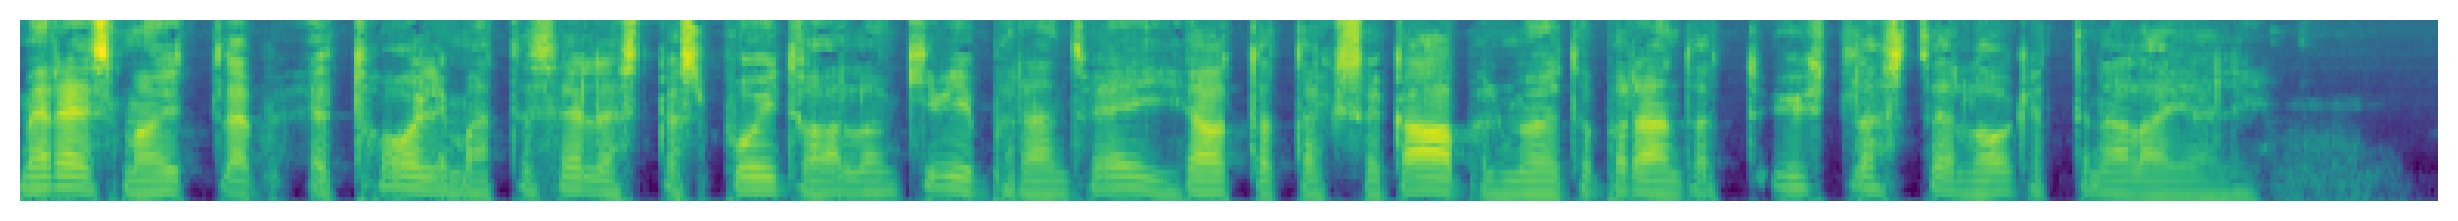

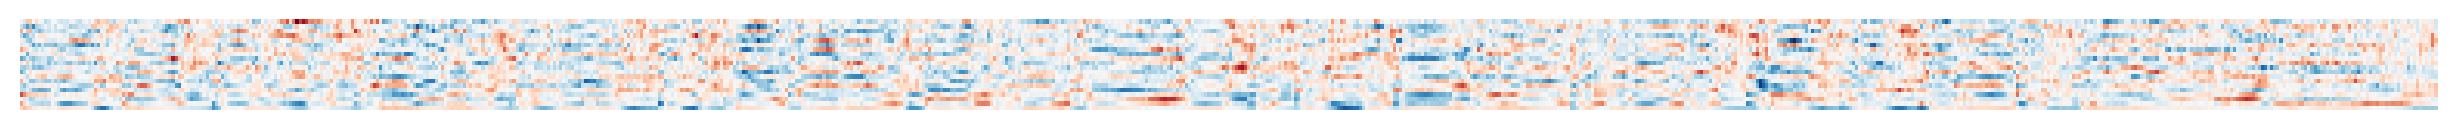

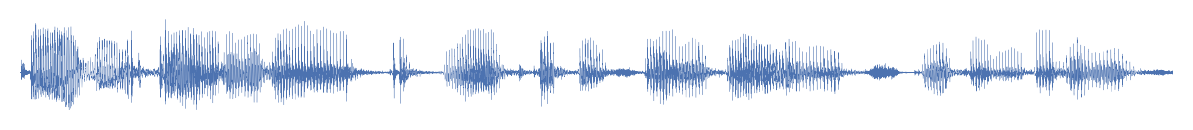

VAD: 4.584 -> 3.74 sec
lang: et
sentence: Keegi ei arva ka, et need ei peaks olema kallimad kui tavaravimid.


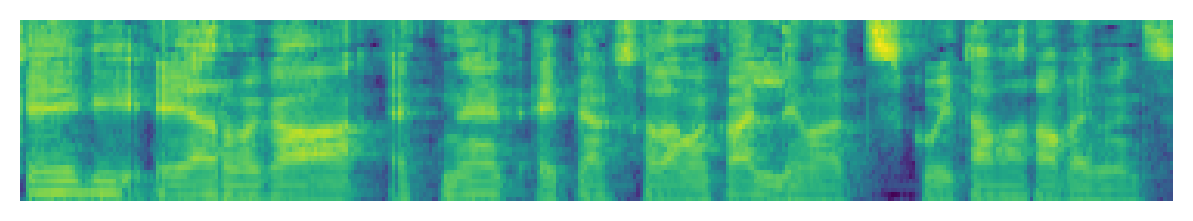

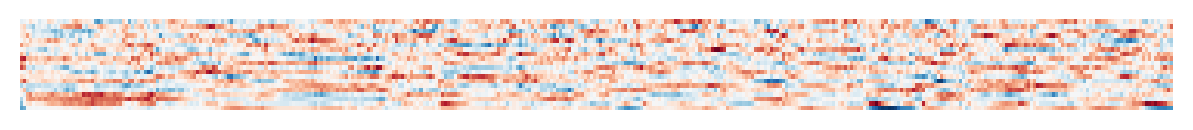

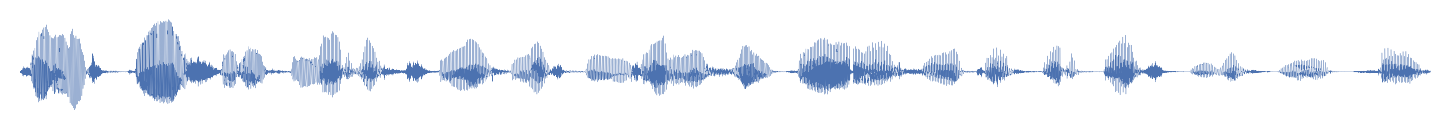

VAD: 6.336 -> 4.57 sec
lang: mn
sentence: Жэймстэй ширүүхэн маргалдсаны улмаас Бенжамин хувь заяагаа хайж олохоор Бостоныг орхин одлоо.


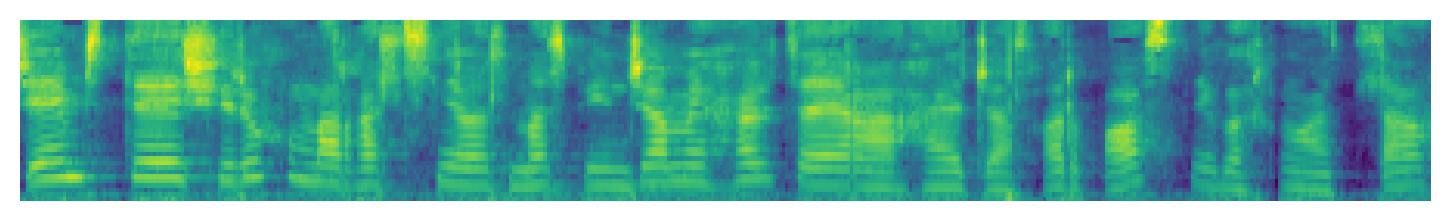

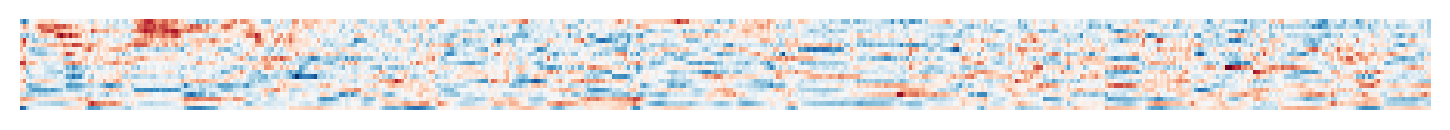

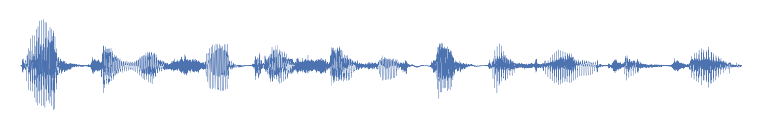

VAD: 3.864 -> 2.35 sec
lang: mn
sentence: Болж өгвөл сүүдрээсээ хүртэл болгоомжилж яв.


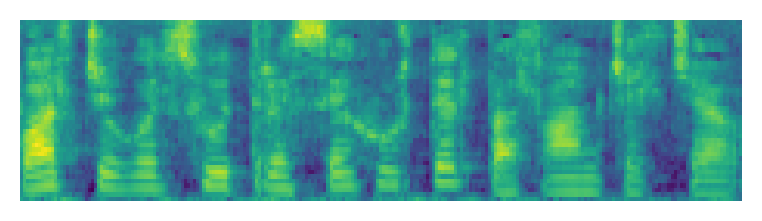

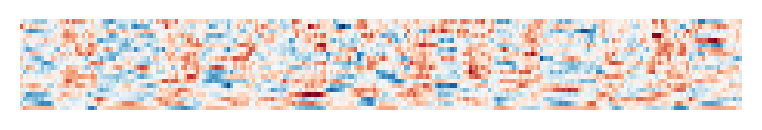

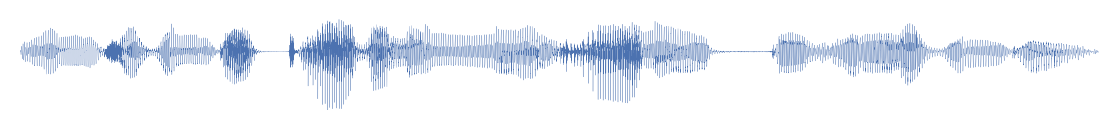

VAD: 5.304 -> 3.5 sec
lang: ta
sentence: மிஞ்சுகின்ற காதலின்மேல் ஆணையிட்டு விள்ளுகின்றேன்!


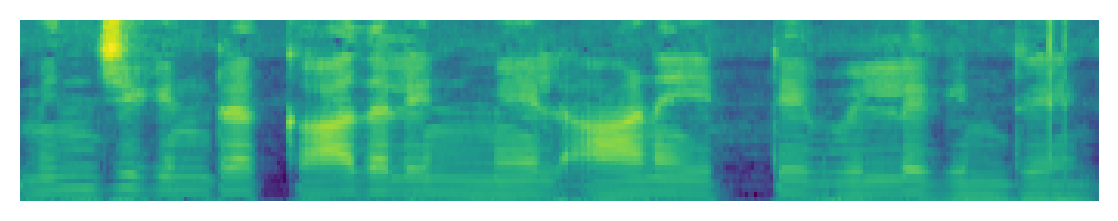

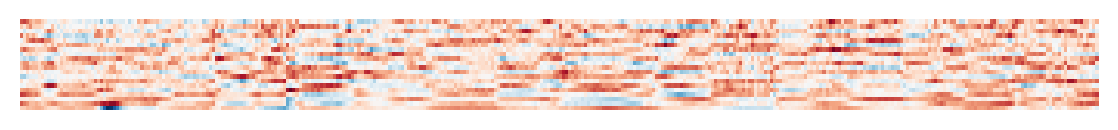

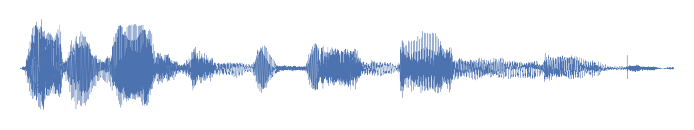

VAD: 3.888 -> 2.13 sec
lang: ta
sentence: தெருவார் வந்து சேர்ந்தார் உள்ளே.


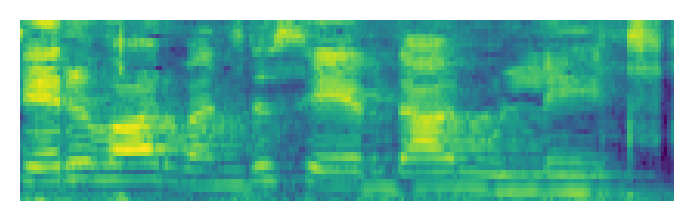

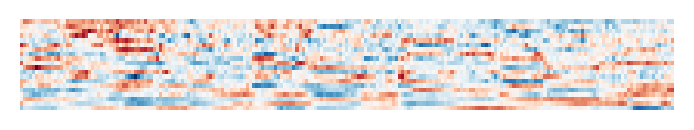

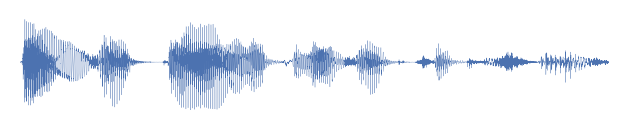

VAD: 3.744 -> 1.92 sec
lang: tr
sentence: Ancak daha yapılacak çok iş var.


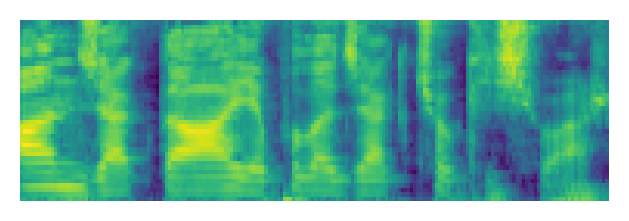

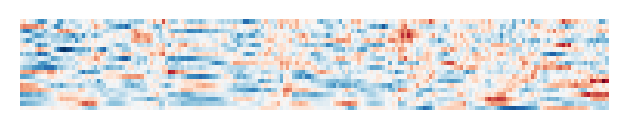

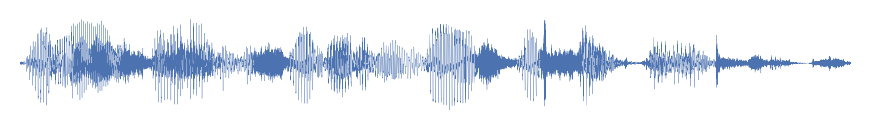

VAD: 4.584 -> 2.7 sec
lang: tr
sentence: Bundan sonra bir şeylerin değişmesi gerekecek.


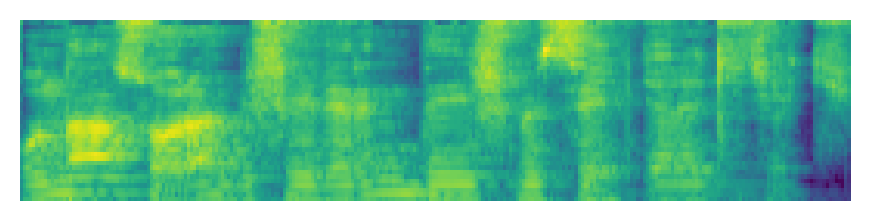

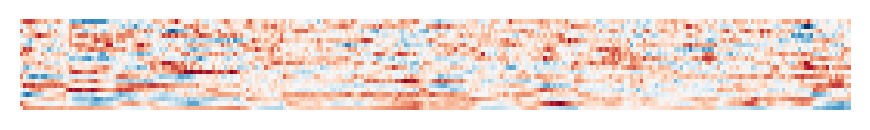

In [23]:
for sentence, lang, clip_path in samples[["sentence", "lang", "path"]].to_numpy():
    signal_before_vad, rate = read_mp3(clip_path)
    signal = remove_silence(signal_before_vad, rate)
    
    logmelspec = logmelspectrograms([signal], rate)[0]
    logmelspec_mvn = cmvn([logmelspec], normalize_variance=False)[0]
    
    mfcc = tf.signal.mfccs_from_log_mel_spectrograms([logmelspec])[0]
    mfcc = mfcc[:,1:21]
    mfcc_cmvn = cmvn([mfcc])[0]
    
    plot_width = logmelspec.shape[0]/50
    plot_signal(signal.numpy(), figsize=(plot_width, .6))
    print("VAD: {} -> {} sec".format(
        signal_before_vad.size / rate,
        signal.numpy().size / rate))
    print("lang:", lang)
    print("sentence:", sentence)
    embed_audio(signal.numpy(), rate)
    
    plot_spectrogram(logmelspec_mvn.numpy(), figsize=(plot_width, 1.2))
    plot_cepstra(mfcc_cmvn.numpy(), figsize=(plot_width, .6))
    
    plot_separator()

## Loading the samples to a `tf.data.Dataset` iterator

Our dataset is relatively small (2.5 GiB) and we might be able to read all files into signals and keep them in main memory.
However, most speech datasets are much larger due to the amount of data needed for training neural network models that would be of any practical use.
We need some kind of lazy iteration or streaming solution that views only one part of the dataset at a time.
One such solution is to represent the dataset as a [TensorFlow iterator](https://www.tensorflow.org/api_docs/python/tf/data/Dataset), which evaluates its contents only when they are needed, similar to the [MapReduce](https://en.wikipedia.org/wiki/MapReduce) programming model for big data.

The downside with lazy iteration or streaming is that we lose the capability of doing random access by row id.
However, this shouldn't be a problem since we can always keep the whole metadata table in memory and do random access on its rows whenever needed.

Another benefit of TensorFlow dataset iterators is that we can map arbitrary [`tf.function`](https://www.tensorflow.org/api_docs/python/tf/function)s over the dataset and TensorFlow will automatically parallelize the computations and place them on different devices, such as the GPU.
The core architecture of `lidbox` has been organized around the `tf.data.Dataset` API, leaving all the heavy lifting for TensorFlow to handle.

But before we load all our speech data, lets warmup with our small random sample of 8 rows.

In [24]:
samples

client_id  \
id                                                                              
et_18309293_train           a1fe9d415a381158a7fb89978304161183e0795c65d0b3...   
et_20816668_train           723cd1a56681e4c3dbeb36ceac204f435fa517dd8a94d4...   
mn_19023260_train           74c6df0d177aacb734c2ea4052772610dcfc860656bd8b...   
mn_18598365_train_copy_695  be1b9005c04889bbf9759a71dbe046be839ee068a668f4...   
ta_19093638_train           6622032a09c9f7e0fbb3bddc0a33304509ca3f33ec79fe...   
ta_20435594_train           7d61a7238caeb62624af2b9c202edbfc534e7955658646...   
tr_19847090_train           7af2e0f706baed314ca0f96efe612ea592bf57791a348b...   
tr_21324796_train           7b735c8f538c3bae9b0d2a63492fb70a49d214173903d3...   

                                                                         path  \
id                                                                              
et_18309293_train           /data/common-voice/cv-corpus/et/clips/common_v...   
et_20816668_train           /data/common-voice/cv-corpus/et/clips/common_v...   
mn_19023260_train           /data/common-voice/cv-corpus/mn/clips/common_v...   
mn_18598365_train_copy_695  /data/common-voice/cv-corpus/mn/clips/common_v...   
ta_19093638_train           /data/common-voice/cv-corpus/ta/clips/common_v...   
ta_20435594_train           /data/common-voice/cv-corpus/ta/clips/common_v...   
tr_19847090_train           /data/common-voice/cv-corpus/tr/clips/common_v...   
tr_21324796_train           /data/common-voice/cv-corpus/tr/clips/common_v...   

                                                                     sentence  \
id                                                                              
et_18309293_train           Meresmaa ütleb, et hoolimata sellest, kas puid...   
et_20816668_train           Keegi ei arva ka, et need ei peaks olema kalli...   
mn_19023260_train           Жэймстэй ширүүхэн маргалдсаны улмаас Бенжамин ...   
mn_18598365_train_copy_695       Болж өгвөл сүүдрээсээ хүртэл болгоомжилж яв.   
ta_19093638_train           மிஞ்சுகின்ற காதலின்மேல் ஆணையிட்டு விள்ளுகின்றேன்!   
ta_20435594_train                            தெருவார் வந்து சேர்ந்தார் உள்ளே.   
tr_19847090_train                            Ancak daha yapılacak çok iş var.   
tr_21324796_train              Bundan sonra bir şeylerin değişmesi gerekecek.   

                           lang  split target duration  
id                                                      
et_18309293_train            et  train      0    8.736  
et_20816668_train            et  train      0    4.584  
mn_19023260_train            mn  train      1    6.336  
mn_18598365_train_copy_695   mn  train      1    3.864  
ta_19093638_train            ta  train      2    5.304  
ta_20435594_train            ta  train      2    3.888  
tr_19847090_train            tr  train      3    3.744  
tr_21324796_train            tr  train      3    4.584

Lets load it into a `tf.data.Dataset`.

In [25]:
def metadata_to_dataset_input(meta):   
    # Create a mapping from column names to all values under the column as tensors
    return {
        "id": tf.constant(meta.index, tf.string),
        "path": tf.constant(meta.path, tf.string),
        "lang": tf.constant(meta.lang, tf.string),
        "target": tf.constant(meta.target, tf.int32),
        "split": tf.constant(meta.split, tf.string),
    }


sample_ds = tf.data.Dataset.from_tensor_slices(metadata_to_dataset_input(samples))
sample_ds

<TensorSliceDataset shapes: {id: (), path: (), lang: (), target: (), split: ()}, types: {id: tf.string, path: tf.string, lang: tf.string, target: tf.int32, split: tf.string}>

All elements produced by the `Dataset` iterator are `dict`s of (string, Tensor) pairs, where the string denotes the metadata type.

Although the `Dataset` object is primarily for automating large-scale data processing pipelines, it is easy to extract all elements as `numpy`-values:

In [26]:
for x in sample_ds.as_numpy_iterator():
    display(x)

{'id': b'et_18309293_train',
 'path': b'/data/common-voice/cv-corpus/et/clips/common_voice_et_18309293.mp3',
 'lang': b'et',
 'target': 0,
 'split': b'train'}

{'id': b'et_20816668_train',
 'path': b'/data/common-voice/cv-corpus/et/clips/common_voice_et_20816668.mp3',
 'lang': b'et',
 'target': 0,
 'split': b'train'}

{'id': b'mn_19023260_train',
 'path': b'/data/common-voice/cv-corpus/mn/clips/common_voice_mn_19023260.mp3',
 'lang': b'mn',
 'target': 1,
 'split': b'train'}

{'id': b'mn_18598365_train_copy_695',
 'path': b'/data/common-voice/cv-corpus/mn/clips/common_voice_mn_18598365.mp3',
 'lang': b'mn',
 'target': 1,
 'split': b'train'}

{'id': b'ta_19093638_train',
 'path': b'/data/common-voice/cv-corpus/ta/clips/common_voice_ta_19093638.mp3',
 'lang': b'ta',
 'target': 2,
 'split': b'train'}

{'id': b'ta_20435594_train',
 'path': b'/data/common-voice/cv-corpus/ta/clips/common_voice_ta_20435594.mp3',
 'lang': b'ta',
 'target': 2,
 'split': b'train'}

{'id': b'tr_19847090_train',
 'path': b'/data/common-voice/cv-corpus/tr/clips/common_voice_tr_19847090.mp3',
 'lang': b'tr',
 'target': 3,
 'split': b'train'}

{'id': b'tr_21324796_train',
 'path': b'/data/common-voice/cv-corpus/tr/clips/common_voice_tr_21324796.mp3',
 'lang': b'tr',
 'target': 3,
 'split': b'train'}

### Reading audio files

Lets load the signals by [mapping](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) a file reading function for each element over the whole dataset.
We'll add a `tf.data.Dataset` function wrapper on top of `read_mp3`, which we defined earlier.
TensorFlow will infer the input and output values of the wrapper as tensors from the type signature of dataset elements.
We must use `tf.numpy_function` if we want to allow calling the non-TensorFlow function `read_mp3` also from
inside the graph environment.
It might not be as efficient as using TensorFlow ops but reading a file would have a lot of latency anyway so this is not such a big hit for performance.
Besides, we can always hide the latency by reading several files in parallel.

In [27]:
def read_mp3_wrapper(x):
    signal, sample_rate = tf.numpy_function(
        # Function
        read_mp3,
        # Argument list
        [x["path"]],
        # Return value types
        [tf.float32, tf.int64])
    return dict(x, signal=signal, sample_rate=tf.cast(sample_rate, tf.int32))


for x in sample_ds.map(read_mp3_wrapper).as_numpy_iterator():
    print("id: {}".format(x["id"].decode("utf-8")))
    print("signal.shape: {}, sample rate: {}".format(x["signal"].shape, x["sample_rate"]))
    print()

id: et_18309293_train
signal.shape: (139776,), sample rate: 16000

id: et_20816668_train
signal.shape: (73344,), sample rate: 16000

id: mn_19023260_train
signal.shape: (101376,), sample rate: 16000

id: mn_18598365_train_copy_695
signal.shape: (61824,), sample rate: 16000

id: ta_19093638_train
signal.shape: (84864,), sample rate: 16000

id: ta_20435594_train
signal.shape: (62208,), sample rate: 16000

id: tr_19847090_train
signal.shape: (59904,), sample rate: 16000

id: tr_21324796_train
signal.shape: (73344,), sample rate: 16000



### Removing silence and extracting features

Organizing all preprocessing steps as functions that can be mapped over the `Dataset` object allows us to represent complex transformations easily.
We can also increase hardware utilization by using large batches when performing expensive computations like feature extraction.
However, our sample currently has signals of different lengths and we cannot batch them into normal tensors (or perhaps we could use [ragged tensors](https://www.tensorflow.org/guide/ragged_tensor)).
Later we will partition all signals into fixed length chunks, which allows us to create fixed sized batches for increased performance (and convenience...).

Lets feature extraction function that supports batches.

In [28]:
def remove_silence_wrapper(x):
    return dict(x, signal=remove_silence(x["signal"], x["sample_rate"]))


def batch_extract_features(x):
    # Try to put all ops on the GPU, or use whatever else is available.
    # Doesn't matter much for our small dataset but can be useful when extracting features
    # from thousands of hours of data.
    with tf.device("GPU"):
        signals, rates = x["signal"], x["sample_rate"]
        logmelspecs = logmelspectrograms(signals, rates[0])
        logmelspecs_smn = cmvn(logmelspecs, normalize_variance=False)
        mfccs = tf.signal.mfccs_from_log_mel_spectrograms(logmelspecs)
        mfccs = mfccs[...,1:21]
        mfccs_cmvn = cmvn(mfccs)
    return dict(x, logmelspec=logmelspecs_smn, mfcc=mfccs_cmvn)


features_ds = (sample_ds.map(read_mp3_wrapper)
                 .map(remove_silence_wrapper)
                 .batch(1)
                 .map(batch_extract_features)
                 .unbatch())

for x in features_ds.as_numpy_iterator():
    print(x["id"])
    for k in ("signal", "logmelspec", "mfcc"):
        print("{}.shape: {}".format(k, x[k].shape))
    print()

b'et_18309293_train'
signal.shape: (125120,)
logmelspec.shape: (780, 40)
mfcc.shape: (780, 20)

b'et_20816668_train'
signal.shape: (59840,)
logmelspec.shape: (372, 40)
mfcc.shape: (372, 20)

b'mn_19023260_train'
signal.shape: (73120,)
logmelspec.shape: (455, 40)
mfcc.shape: (455, 20)

b'mn_18598365_train_copy_695'
signal.shape: (37600,)
logmelspec.shape: (233, 40)
mfcc.shape: (233, 20)

b'ta_19093638_train'
signal.shape: (56000,)
logmelspec.shape: (348, 40)
mfcc.shape: (348, 20)

b'ta_20435594_train'
signal.shape: (34080,)
logmelspec.shape: (211, 40)
mfcc.shape: (211, 20)

b'tr_19847090_train'
signal.shape: (30720,)
logmelspec.shape: (190, 40)
mfcc.shape: (190, 20)

b'tr_21324796_train'
signal.shape: (43200,)
logmelspec.shape: (268, 40)
mfcc.shape: (268, 20)



### Dumping data to TensorBoard lazily

`lidbox` has a helper function for dumping element information into [`TensorBoard`](https://www.tensorflow.org/tensorboard) summaries.
This converts all 2D features into images, writes signals as audio summaries, and extracts utterance ids.

In [29]:
import lidbox.dataset.steps as ds_steps


_ = ds_steps.consume_to_tensorboard(
    # Rename logmelspec as 'input', these will be plotted as images
    ds=features_ds.map(lambda x: dict(x, input=x["logmelspec"])),
    summary_dir=os.path.join("tensorboard", "dataset", "sample"),
    config={"batch_size": 1, "image_size_multiplier": 4},
    exist_ok=True)

2020-11-02 00:32:13.364 I lidbox.dataset.steps: Writing 1 first elements of -1 batches, each of size 1, into Tensorboard summaries in 'tensorboard/dataset/sample'
Instructions for updating:
Use fn_output_signature instead


2020-11-02 00:32:14.134 W tensorflow: From /usr/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:574: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead


2020-11-02 00:32:14.427 I lidbox.dataset.steps: Exhausting the dataset iterator by iterating over all elements, log_interval = -1
2020-11-02 00:32:16.348 I lidbox.dataset.steps: 8 done, 4.167 elements per second.


Open a terminal and launch TensorBoard to view the summaries written in `./tensorboard/dataset/sample`:
```
tensorboard --logdir ./tensorboard
```
Then open the url in a browser and inspect the contents.
You can leave the server running, since we'll log the training progress to the same directory.

## Loading all data

We'll now begin loading everything from disk and preparing a pipeline from mp3-filepaths to neural network input.
We'll use the autotune feature of `tf.data` to allow TensorFlow figure out automatically how much of the pipeline should be split up into parallel calls.
`lidbox` provides some helper functions implemented only using tensors for efficient preprocessing with `tf.data.Dataset` pipelines.

We will chunk all signals into 2 second segments, with 0.5 second overlap to allow batching.
But what should we do with signals that are shorter than 2 seconds?
We don't want to discard valuable, labeled information.
[One approach](https://ieeexplore.ieee.org/abstract/document/8520780) is to apply data augmentation by speeding up and slowing down the signal and then concatenating all three versions into a single signal.
Let's use a simpler approach where we repeatedly append the signal to itself until it is 2 seconds or longer.


In [30]:
import lidbox.dataset.steps as ds_steps

TF_AUTOTUNE = tf.data.experimental.AUTOTUNE


def create_signal_chunks(ds):
    # Append every signal to itself until the signal is longer than 2 seconds
    ds = ds_steps.repeat_too_short_signals(ds, 2000)
    # Create 2 second chunks from each audio signal, with 0.5 seconds overlap
    # Trailing chunks are dropped
    return ds_steps.create_signal_chunks(ds, 2000, 1500)


def pipeline_from_metadata(data, shuffle=False):
    if shuffle:
        # Shuffle metadata to get an even distribution of labels
        data = data.sample(frac=1, random_state=np_rng.bit_generator)
    ds = (
        # Initialize dataset from metadata
        tf.data.Dataset.from_tensor_slices(metadata_to_dataset_input(data))
        # Read mp3 files from disk in parallel
        .map(read_mp3_wrapper, num_parallel_calls=TF_AUTOTUNE)
        # Apply RMS VAD to drop silence from all signals
        .map(remove_silence_wrapper, num_parallel_calls=TF_AUTOTUNE)
        # Drop all elements that have empty signals (VAD removed everything)
        .apply(ds_steps.drop_empty)
        # Create fixed length 2 second chunks from all signals (metadata is duplicated)
        .apply(create_signal_chunks)
        # Batch all 2 second signals into batches of 400 samples
        .batch(400)
        # Extract features from 400 signals at a time in parallel
        .map(batch_extract_features, num_parallel_calls=TF_AUTOTUNE)
        # Flatten all batches (remove 0th tensor rank)
        .unbatch()
    )
    return ds


# Mapping from dataset split names to tf.data.Dataset objects
split2ds = {
    split: pipeline_from_metadata(meta[meta["split"]==split], shuffle=split=="train")
    for split in split_names
}

2020-11-02 00:32:16.447 I lidbox.dataset.steps: Dropping every element which have an empty tensor at any of the non-scalar element keys:
  signal
  input
2020-11-02 00:32:16.482 I lidbox.dataset.steps: Repeating all signals until they are at least 2000 ms
2020-11-02 00:32:16.520 I lidbox.dataset.steps: Dividing every signal in the dataset into new signals by creating signal chunks of length 2000 ms and offset 1500 ms. Maximum amount of padding allowed in the last chunk is 0 ms.
2020-11-02 00:32:16.928 I lidbox.dataset.steps: Dropping every element which have an empty tensor at any of the non-scalar element keys:
  signal
  input
2020-11-02 00:32:16.935 I lidbox.dataset.steps: Repeating all signals until they are at least 2000 ms
2020-11-02 00:32:16.942 I lidbox.dataset.steps: Dividing every signal in the dataset into new signals by creating signal chunks of length 2000 ms and offset 1500 ms. Maximum amount of padding allowed in the last chunk is 0 ms.
2020-11-02 00:32:17.135 I lidbox.d

### Testing pipeline performance

Note that we only constructed the pipeline with all steps we want to compute.
All TensorFlow ops are computed only when elements are requested from the iterator.

Lets iterate over the training dataset from first to last element to ensure the pipeline will not be a performance bottleneck during training.

In [31]:
_ = ds_steps.consume(split2ds["train"], log_interval=2000)

2020-11-02 00:32:17.311 I lidbox.dataset.steps: Exhausting the dataset iterator by iterating over all elements, log_interval = 2000
2020-11-02 00:32:23.266 I lidbox.dataset.steps: 2000 done, 335.841 elements per second.
2020-11-02 00:32:27.813 I lidbox.dataset.steps: 4000 done, 440.022 elements per second.
2020-11-02 00:32:32.306 I lidbox.dataset.steps: 6000 done, 445.167 elements per second.
2020-11-02 00:32:36.867 I lidbox.dataset.steps: 8000 done, 438.573 elements per second.
2020-11-02 00:32:41.574 I lidbox.dataset.steps: 10000 done, 425.001 elements per second.
2020-11-02 00:32:46.217 I lidbox.dataset.steps: 12000 done, 430.793 elements per second.
2020-11-02 00:32:50.785 I lidbox.dataset.steps: 14000 done, 437.949 elements per second.
2020-11-02 00:32:55.484 I lidbox.dataset.steps: 16000 done, 425.642 elements per second.
2020-11-02 00:33:00.145 I lidbox.dataset.steps: 18000 done, 429.144 elements per second.
2020-11-02 00:33:04.601 I lidbox.dataset.steps: 20000 done, 448.969 ele

### Caching pipeline state

We can [cache](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) the iterator state as a single binary file at arbitrary stages.
This allows us to automatically skip all steps that precede the call to `tf.Dataset.cache`.

Lets cache the training dataset and iterate again over all elements to fill the cache.
**Note** that you will still be storing all data on the disk (4.6 GiB new data), so this optimization is a space-time tradeoff.

In [32]:
os.makedirs("cache")

split2ds["train"] = split2ds["train"].cache(os.path.join("cache", "train"))
_ = ds_steps.consume(split2ds["train"], log_interval=2000)

2020-11-02 00:33:22.315 I lidbox.dataset.steps: Exhausting the dataset iterator by iterating over all elements, log_interval = 2000
2020-11-02 00:33:28.432 I lidbox.dataset.steps: 2000 done, 327.002 elements per second.
2020-11-02 00:33:33.018 I lidbox.dataset.steps: 4000 done, 436.211 elements per second.
2020-11-02 00:33:37.587 I lidbox.dataset.steps: 6000 done, 437.738 elements per second.
2020-11-02 00:33:42.125 I lidbox.dataset.steps: 8000 done, 440.805 elements per second.
2020-11-02 00:33:46.710 I lidbox.dataset.steps: 10000 done, 436.288 elements per second.
2020-11-02 00:33:51.365 I lidbox.dataset.steps: 12000 done, 429.724 elements per second.
2020-11-02 00:33:55.983 I lidbox.dataset.steps: 14000 done, 433.099 elements per second.
2020-11-02 00:34:00.664 I lidbox.dataset.steps: 16000 done, 427.334 elements per second.
2020-11-02 00:34:05.161 I lidbox.dataset.steps: 18000 done, 444.791 elements per second.
2020-11-02 00:34:09.915 I lidbox.dataset.steps: 20000 done, 420.806 ele

If we iterate over the dataset again, TensorFlow should read all elements from the cache file.

In [33]:
_ = ds_steps.consume(split2ds["train"], log_interval=2000)

2020-11-02 00:34:27.957 I lidbox.dataset.steps: Exhausting the dataset iterator by iterating over all elements, log_interval = 2000
2020-11-02 00:34:28.435 I lidbox.dataset.steps: 2000 done, 4190.363 elements per second.
2020-11-02 00:34:28.828 I lidbox.dataset.steps: 4000 done, 5101.372 elements per second.
2020-11-02 00:34:29.221 I lidbox.dataset.steps: 6000 done, 5101.240 elements per second.
2020-11-02 00:34:29.614 I lidbox.dataset.steps: 8000 done, 5098.533 elements per second.
2020-11-02 00:34:30.004 I lidbox.dataset.steps: 10000 done, 5130.526 elements per second.
2020-11-02 00:34:30.398 I lidbox.dataset.steps: 12000 done, 5083.056 elements per second.
2020-11-02 00:34:30.790 I lidbox.dataset.steps: 14000 done, 5111.173 elements per second.
2020-11-02 00:34:31.176 I lidbox.dataset.steps: 16000 done, 5192.123 elements per second.
2020-11-02 00:34:31.555 I lidbox.dataset.steps: 18000 done, 5287.350 elements per second.
2020-11-02 00:34:31.933 I lidbox.dataset.steps: 20000 done, 52

As a side note, if your training environment has fast read-write access to a file system configured for reading and writing very large files, this optimization can be a very significant performance improvement.

**Note** also that all usual problems related to cache invalidation apply.
When caching extracted features and metadata to disk, be extra careful in your experiments to ensure you are not interpreting results computed on data from some outdated cache.

### Dumping a few batches to TensorBoard 

Lets extract 320 first elements of every split to TensorBoard.

In [34]:
for split, ds in split2ds.items():
    _ = ds_steps.consume_to_tensorboard(
            ds.map(lambda x: dict(x, input=x["logmelspec"])),
            os.path.join("tensorboard", "dataset", split),
            {"batch_size": 16,
             "image_size_multiplier": 4,
             "num_batches": 20},
            exist_ok=True)

2020-11-02 00:34:33.456 I lidbox.dataset.steps: Writing 16 first elements of 20 batches, each of size 16, into Tensorboard summaries in 'tensorboard/dataset/train'
2020-11-02 00:34:33.666 I lidbox.dataset.steps: Exhausting the dataset iterator by iterating over all elements, log_interval = -1
2020-11-02 00:34:42.166 I lidbox.dataset.steps: 320 done, 37.651 elements per second.
2020-11-02 00:34:42.177 I lidbox.dataset.steps: Writing 16 first elements of 20 batches, each of size 16, into Tensorboard summaries in 'tensorboard/dataset/dev'
2020-11-02 00:34:42.388 I lidbox.dataset.steps: Exhausting the dataset iterator by iterating over all elements, log_interval = -1
2020-11-02 00:35:11.584 I lidbox.dataset.steps: 320 done, 10.960 elements per second.
2020-11-02 00:35:11.596 I lidbox.dataset.steps: Writing 16 first elements of 20 batches, each of size 16, into Tensorboard summaries in 'tensorboard/dataset/test'
2020-11-02 00:35:11.808 I lidbox.dataset.steps: Exhausting the dataset iterator

## Training a supervised, neural network language classifier

We have now configured an efficient data pipeline and extracted some data samples to summary files for TensorBoard.
It is time to train a classifier on the data.

### Drop metadata from dataset

During training, we only need a tuple of model input and targets.
We can therefore drop everything else from the dataset elements just before training starts.
This is also a good place to decide if we want to train on MFCCs or Mel-spectra.

(198, 40) ta


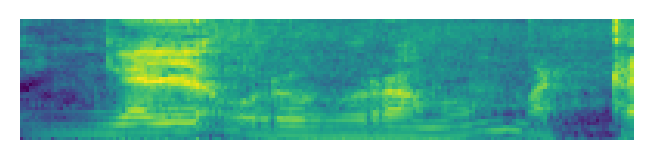

(198, 40) mn


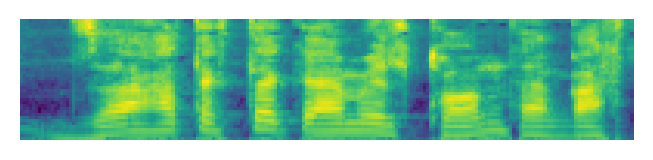

(198, 40) et


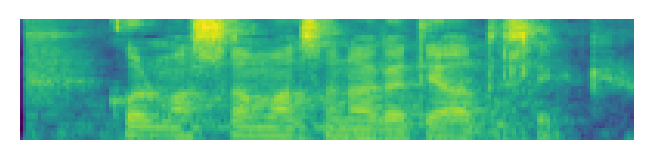

(198, 40) et


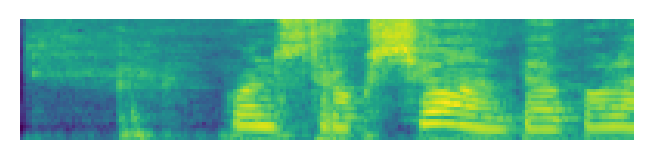

(198, 40) mn


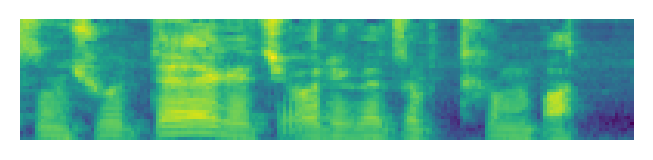

(198, 40) et


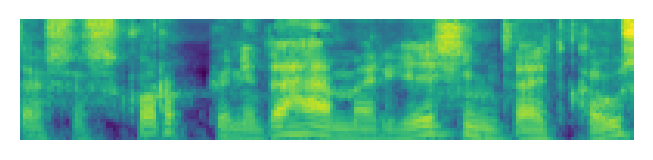

In [35]:
model_input_type = "logmelspec"

def as_model_input(x):
    return x[model_input_type], x["target"]


train_ds_demo = split2ds["train"].map(as_model_input).shuffle(1000)

for input, target in train_ds_demo.take(6).as_numpy_iterator():
    print(input.shape, target2lang[target])
    if model_input_type == "mfcc":
        plot_cepstra(input)
    else:
        plot_spectrogram(input)
    plot_separator()

### Asserting all input is valid

Since the training dataset is cached, we can quickly iterate over all elements and check that we don't have any NaNs or negative targets.

In [36]:
def assert_finite(x, y):
    tf.debugging.assert_all_finite(x, "non-finite input")
    tf.debugging.assert_non_negative(y, "negative target")
    return x, y

_ = ds_steps.consume(split2ds["train"].map(as_model_input).map(assert_finite), log_interval=5000)

2020-11-02 00:35:42.363 I lidbox.dataset.steps: Exhausting the dataset iterator by iterating over all elements, log_interval = 5000
2020-11-02 00:35:43.448 I lidbox.dataset.steps: 5000 done, 4611.319 elements per second.
2020-11-02 00:35:44.334 I lidbox.dataset.steps: 10000 done, 5650.378 elements per second.
2020-11-02 00:35:45.246 I lidbox.dataset.steps: 15000 done, 5485.755 elements per second.
2020-11-02 00:35:46.162 I lidbox.dataset.steps: 20000 done, 5464.538 elements per second.
2020-11-02 00:35:47.046 I lidbox.dataset.steps: 25000 done, 5659.748 elements per second.
2020-11-02 00:35:47.543 I lidbox.dataset.steps: 27845 done, 5731.168 elements per second.


It is also easy to compute stats on the dataset elements.
For example finding global minimum and maximum values of the inputs.

In [37]:
x_min = split2ds["train"].map(as_model_input).reduce(
    tf.float32.max,
    lambda acc, elem: tf.math.minimum(acc, tf.math.reduce_min(elem[0])))

x_max = split2ds["train"].map(as_model_input).reduce(
    tf.float32.min,
    lambda acc, elem: tf.math.maximum(acc, tf.math.reduce_max(elem[0])))

print("input tensor global minimum: {}, maximum: {}".format(x_min.numpy(), x_max.numpy()))

input tensor global minimum: -19.749370574951172, maximum: 14.27511978149414


### Selecting a model architecture

`lidbox` provides a small set of neural network model architectures out of the box.
Many of these architectures have good results in the literature for different datasets.
These models have been implemented in Keras, so you could replace the model we are using here with anything you want.

The ["x-vector" model](http://danielpovey.com/files/2018_odyssey_xvector_lid.pdf) architecture has worked well in language identification so lets create an untrained Keras model instance out of it.
Lets also try to regularize the network by adding frequency [channel dropout](https://dl.acm.org/doi/abs/10.1016/j.patrec.2017.09.023) with probability 0.8.
In other words, during training we set input rows randomly to zeros with probability 0.8.
This might avoid the network overfitting on frequency channels with noise that is irrelevant for deciding the language.

In [38]:
import lidbox.models.xvector as xvector


def create_model(num_freq_bins, num_labels):
    model = xvector.create([None, num_freq_bins], num_labels, channel_dropout_rate=0.8)
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5))
    return model


model = create_model(
    num_freq_bins=20 if model_input_type == "mfcc" else 40,
    num_labels=len(target2lang))
model.summary()

Model: "x-vector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 40)]        0         
_________________________________________________________________
channel_dropout (SpatialDrop (None, None, 40)          0         
_________________________________________________________________
frame1 (Conv1D)              (None, None, 512)         102912    
_________________________________________________________________
frame2 (Conv1D)              (None, None, 512)         786944    
_________________________________________________________________
frame3 (Conv1D)              (None, None, 512)         786944    
_________________________________________________________________
frame4 (Conv1D)              (None, None, 512)         262656    
_________________________________________________________________
frame5 (Conv1D)              (None, None, 1500)        769

### Channel dropout demo

Here's what happens to the input during training.

(198, 40) mn


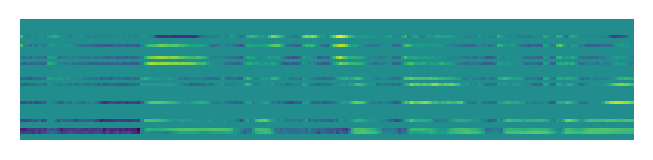

(198, 40) ta


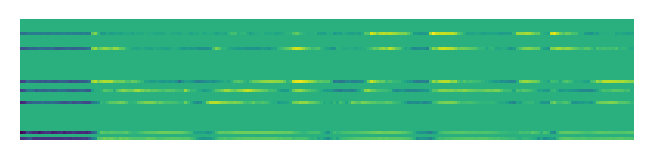

(198, 40) tr


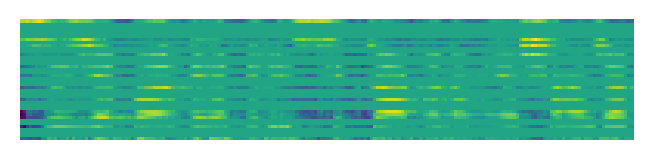

(198, 40) tr


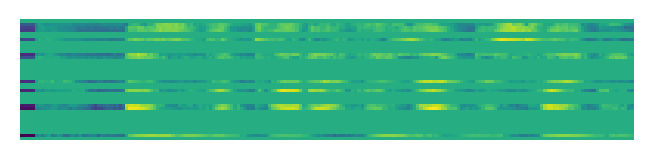

(198, 40) ta


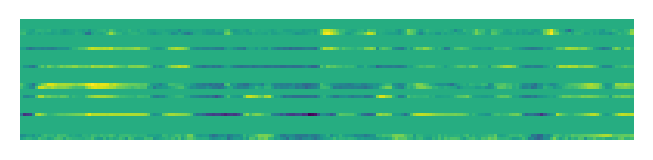

(198, 40) tr


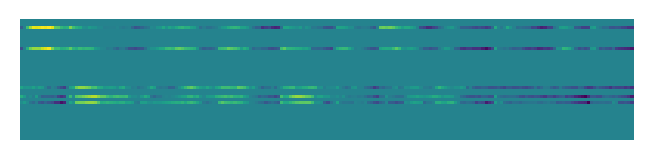

In [39]:
channel_dropout = tf.keras.layers.SpatialDropout1D(model.get_layer("channel_dropout").rate)

for input, target in train_ds_demo.take(6).as_numpy_iterator():
    print(input.shape, target2lang[target])
    input = channel_dropout(tf.expand_dims(input, 0), training=True)[0].numpy()
    if model_input_type == "mfcc":
        plot_cepstra(input)
    else:
        plot_spectrogram(input)
    plot_separator()

### Training the classifier

The validation set is needed after every epoch, so we might as well cache it.
**Note** that this writes 2.5 GiB of additional data to disk the first time the validation set is iterated over, i.e. at the end of epoch 1.

In [40]:
callbacks = [
    # Write scalar metrics and network weights to TensorBoard
    tf.keras.callbacks.TensorBoard(
        log_dir=os.path.join("tensorboard", model.name),
        update_freq="epoch",
        write_images=True,
        profile_batch=0,
    ),
    # Stop training if validation loss has not improved from the global minimum in 10 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
    ),
    # Write model weights to cache everytime we get a new global minimum loss value
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join("cache", model.name),
        monitor='val_loss',
        save_weights_only=True,
        save_best_only=True,
        verbose=1,
    ),
]

dev_ds = split2ds["dev"].cache(os.path.join("cache", "dev")).map(as_model_input)

history = model.fit(
    split2ds["train"].map(as_model_input).shuffle(200*32).batch(32),
    validation_data=dev_ds.batch(32),
    callbacks=callbacks,
    verbose=2,
    epochs=100)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.25420, saving model to cache/x-vector
871/871 - 47s - loss: 1.3298 - val_loss: 1.2542
Epoch 2/100

Epoch 00002: val_loss improved from 1.25420 to 1.05073, saving model to cache/x-vector
871/871 - 13s - loss: 1.2051 - val_loss: 1.0507
Epoch 3/100

Epoch 00003: val_loss improved from 1.05073 to 1.00242, saving model to cache/x-vector
871/871 - 13s - loss: 1.0960 - val_loss: 1.0024
Epoch 4/100

Epoch 00004: val_loss improved from 1.00242 to 0.89718, saving model to cache/x-vector
871/871 - 13s - loss: 1.0421 - val_loss: 0.8972
Epoch 5/100

Epoch 00005: val_loss did not improve from 0.89718
871/871 - 13s - loss: 0.9923 - val_loss: 0.9030
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.89718
871/871 - 13s - loss: 0.9659 - val_loss: 1.0313
Epoch 7/100

Epoch 00007: val_loss did not improve from 0.89718
871/871 - 13s - loss: 0.9341 - val_loss: 0.9430
Epoch 8/100

Epoch 00008: val_loss improved from 0.89718 to 0.82635, saving 

## Evaluating the classifier


Lets run all test set samples through our trained model.
First we cache the test dataset and then load best weights for the model.
**Note** that caching the test dataset writes an additional 2.6 GiB data.

In [41]:
test_ds = split2ds["test"].cache(os.path.join("cache", "test"))
ds_steps.consume(test_ds)

_ = model.load_weights(os.path.join("cache", model.name))

2020-11-02 00:45:58.450 I lidbox.dataset.steps: Exhausting the dataset iterator by iterating over all elements, log_interval = -1
2020-11-02 00:46:34.387 I lidbox.dataset.steps: 15298 done, 425.704 elements per second.


In [42]:
# Predictions are returned as a flattened (unbatched) numpy array
predictions = model.predict(test_ds.map(as_model_input).batch(32))
test_meta = meta[meta["split"]=="test"]
print(predictions.shape, "predictions for", test_meta.shape[0], "test set samples")

(15298, 4) predictions for 7569 test set samples


The model predicted 15298 scores for 4 different classes, but the test set contains only 7569 samples.

Recall that we chunked all input into fixed length 2 second chunks, with 0.5 second overlap.

In [43]:
for pred, x in zip(predictions, test_ds.take(20).as_numpy_iterator()):
    print(x["id"], x["lang"], "predicted as", target2lang[pred.argmax()])

b'et_18031888_test-000001' b'et' predicted as tr
b'et_18031888_test-000002' b'et' predicted as et
b'et_18031888_test-000003' b'et' predicted as ta
b'et_18031889_test-000001' b'et' predicted as et
b'et_18031889_test-000002' b'et' predicted as et
b'et_18031889_test-000003' b'et' predicted as et
b'et_18031889_test-000004' b'et' predicted as ta
b'et_18031889_test-000005' b'et' predicted as ta
b'et_18031891_test-000001' b'et' predicted as et
b'et_18038135_test-000001' b'et' predicted as et
b'et_18038135_test-000002' b'et' predicted as mn
b'et_18038135_test-000003' b'et' predicted as mn
b'et_18038135_test-000004' b'et' predicted as et
b'et_18038135_test-000005' b'et' predicted as et
b'et_18038136_test-000001' b'et' predicted as et
b'et_18038136_test-000002' b'et' predicted as et
b'et_18038136_test-000003' b'et' predicted as et
b'et_18038137_test-000001' b'et' predicted as mn
b'et_18038137_test-000002' b'et' predicted as mn
b'et_18038137_test-000003' b'et' predicted as mn


### Merging chunk predictions by averaging

`lidbox` generates new ids for the chunks by appending the enumeration of the chunk to the original id.
For example `uttid-000001`, `uttid-000002`, `uttid-000003`, ... for all chunks.
This makes it easy to group all chunk predictions by the parent id.

Lets combine the utterance ids with each prediction and then merge all chunk predictions by averaging the log-softmax scores.
**Note** that `lidbox` assumes the test dataset is *never* shuffled.

In [44]:
from lidbox.api import merge_chunk_predictions

# Create a mapping from utterance ids to predictions
# tf.string values are utf-8 encoded bytes and must be decoded if they are to be used 
# as Python strings
utt2pred = ((x["id"].decode("utf-8"), pred)
             for x, pred in zip(test_ds.as_numpy_iterator(), predictions))
utt2pred = list(merge_chunk_predictions(utt2pred))

# Same for true classes
utt2true = dict(test_meta.target.iteritems())

print("predictions:", len(utt2pred))
print("true labels:", len(utt2true))

predictions: 7569
true labels: 7569


### Accuracy

In [45]:
y_pred = np.array([pred.argmax() for _, pred in utt2pred], np.int32)
y_true = np.array([utt2true[utt] for utt, _ in utt2pred], np.int32)

print("Accuracy: {:.3f}".format((y_pred == y_true).sum() / y_true.size))

Accuracy: 0.738


### $\text{C}_\text{avg}$ and $\text{F}_1$

The de facto standard metric for evaluating spoken language classifiers might be the *average detection cost* ($\text{C}_\text{avg}$), which has been refined to its current form during past [language recognition competitions](https://tsapps.nist.gov/publication/get_pdf.cfm?pub_id=925272).
`lidbox` provides this metric as a `tf.keras.Metric` subclass.
Scikit-learn provides other commonly used metrics so there is no need to manually compute those.

2020-11-02 00:46:39.524 I lidbox.api: Stacking predictions to numpy arrays
2020-11-02 00:46:39.544 I lidbox.api: Evaluating metrics on true labels of shape (7569,) and predicted labels of shape (7569,). Min prediction score -13.213 max prediction score -0.001
2020-11-02 00:46:39.545 I lidbox.api: Evaluating minimum average detection cost
2020-11-02 00:46:39.688 I lidbox.api: sparse_average_detection_cost: 0.176910
2020-11-02 00:46:39.688 I lidbox.api: Generating full sklearn classification report
2020-11-02 00:46:39.696 I lidbox.api: sklearn_classification_report:
  accuracy: 0.7376139516448672
  et:
    f1-score: 0.7982532751091703
    precision: 0.7048118445404071
    recall: 0.9202577527184858
    support: 2483
  macro avg:
    f1-score: 0.7107031778870406
    precision: 0.7457100678966884
    recall: 0.7163949584880422
    support: 7569
  mn:
    f1-score: 0.7251389746757257
    precision: 0.8221288515406162
    recall: 0.6486187845303868
    support: 1810
  ta:
    f1-score: 0.815

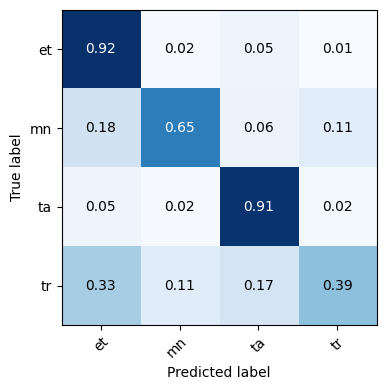

In [46]:
from lidbox.api import evaluate_metrics_for_predictions
from lidbox.visualization import draw_confusion_matrix


eval_conf = [
    {"name": "sparse_average_detection_cost"},
    {"name": "sklearn_classification_report"},
    {"name": "confusion_matrix"},
]
metrics = {m["name"]: m["result"] for m in
           evaluate_metrics_for_predictions(utt2pred, utt2true, eval_conf, target2lang)}

fig, ax = draw_confusion_matrix(metrics["confusion_matrix"], target2lang)

## Conclusions

This was an example on deep learning based simple spoken language identification of 4 different languages from the Mozilla Common Voice free speech datasets.
We managed to train a model that adequately recognizes languages spoken by the test set speakers.

However, there is clearly room for improvement.
We did simple random oversampling to balance the language distribution in the training set, but perhaps there are better ways to do this.
We also did not tune optimization hyperparameters or try different neural network architectures or layer combinations.

#### TODO: e2e config file for CLI